<center>
    <span style="color: teal; font-size: 24px; font-weight: bold;">Lead Scoring Case Study</span>
</center>

<span style="color: maroon; font-size: 20px; font-weight: bold;">Problem Statement</span>

An X Education need help to select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires us to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

<span style="color: maroon; font-size: 20px; font-weight: bold;">Goals of the Case Study</span>

- Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.
- There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

<span style="color: maroon; font-size: 20px; font-weight: bold;">Approach / Steps to Follow</span>

To achieve the goals outlined above, the following steps will be taken:

1. **Data Understanding**: Load the dataset and get familiar with its structure (features, missing values, etc.).
2. **Data Cleaning**: Handle missing values, outliers, and incorrect data types to prepare the data for analysis.
3. **Exploratory Data Analysis (EDA)**: Perform univariate and bivariate analysis to understand key relationships and insights from the data.
4. **Feature Engineering**: Create or transform features to enhance the predictive power of the model.
5. **Model Building**: Build a logistic regression model to predict lead conversion and assign lead scores.
6. **Model Evaluation**: Evaluate the model using appropriate metrics such as accuracy, precision, recall, and the F1 score.
7. **Optimization**: Optimize the model based on performance metrics and business requirements.
8. **Final Model**: Present the final model and recommendations.

We will now begin by importing the necessary libraries and loading the data.


In [1]:
# Importing the NumPy and Pandas packages
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import stats library=
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#import sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score, confusion_matrix, precision_recall_curve

# Ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting common display options

sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", 200)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [3]:
# defining common functions and variables used across the notebook

# function to print missing value composition of columns in a df
def show_missing(df, sorted=True):
    # Calculate the percentage of missing values in each column
    missing_percentage = round((df.isnull().sum() / len(leads)) * 100,2)

    # return the percentage of missing values as per order arg
    if sorted == True:
        return missing_percentage.sort_values(ascending=False)
    else:
        return missing_percentage

# function to show the accuracy, confusion matrix and other evaluatory details of the logistic regression model
def show_confusion_mets(df, col1, col2):
    # checking the overall accuracy.

    print("Accuracy :", round(metrics.accuracy_score(df[col1], df[col2])*100,2))

    # using confusion matrix to check output

    confusion = metrics.confusion_matrix(df[col1], df[col2])
    print('Confusion Matrix :')
    print('-'*20)
    print(confusion)
    print('-'*20)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    # sensitivity of our logistic regression model
    print('Sensitivity :', round((TP / float(TP+FN))*100,2))

    # calculate specificity
    print('Specificity :', round((TN / float(TN+FP))*100,2))

    # Calculate false postive rate - predicting conversion when customer has not converted
    print('False Positive Rate :', round((FP/ float(TN+FP))*100,2))

    # positive predictive value 
    print('Positive predictive power :', round((TP / float(TP+FP))*100,2))

    # negative predictive value
    print('Negative predictive power :', round((TN / float(TN+ FN))*100,2))

    # Calculate metrics like Precision, Recall, F1-score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    print('Precision :', round(precision*100,2))

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    print('Recall :', round(recall*100,2))

    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print('F1 score:', round(f1*100,2))

#Function to build a model using statsmodel api
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
    res = lm.fit()
    print(res.summary())
    return res


#Function to calculate VIFs and print them -Takes the columns for which VIF to be calcualted as a parameter
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

# common variables

num_cols = []
cat_cols = []

In [4]:
# extracting the data
leads = pd.read_csv("Leads.csv")

# viewing the dataframe
leads.head()

Prospect ID  Lead Number              Lead Origin     Lead Source Do Not Email Do Not Call  Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit            Last Activity Country           Specialization How did you hear about X Education What is your current occupation What matters most to you in choosing a course Search Magazine Newspaper Article X Education Forums Newspaper Digital Advertisement Through Recommendations Receive More Updates About Our Courses                                 Tags      Lead Quality Update me on Supply Chain Content Get updates on DM Content    Lead Profile    City Asymmetrique Activity Index Asymmetrique Profile Index  Asymmetrique Activity Score  Asymmetrique Profile Score I agree to pay the amount through cheque A free copy of Mastering The Interview Last Notable Activity
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API      Olark Chat           No          No          0          0.0                            0                   0.0  Page Visited on Website     NaN                   Select                             Select                      Unemployed                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No          Interested in other courses  Low in Relevance                                No                        No          Select  Select                   02.Medium                  02.Medium                         15.0                        15.0                                       No                                     No              Modified
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API  Organic Search           No          No          0          5.0                          674                   2.5             Email Opened   India                   Select                             Select                      Unemployed                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No                              Ringing               NaN                                No                        No          Select  Select                   02.Medium                  02.Medium                         15.0                        15.0                                       No                                     No          Email Opened
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission  Direct Traffic           No          No          1          2.0                         1532                   2.0             Email Opened   India  Business Administration                             Select                         Student                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No  Will revert after reading the email          Might be                                No                        No  Potential Lead  Mumbai                   02.Medium                    01.High                         14.0                        20.0                                       No                                    Yes          Email Opened
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission  Direct Traffic           No          No          0          1.0                          305                   1.0              Unreachable   India    Media and Advertising                      Word Of Mouth                      Unemployed                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No                              Ringing          Not S

In [5]:
#Checking the Shape of dataset
leads.shape

(9240, 37)

In [6]:
# Checking the summary of the dataset
leads.describe()

Lead Number    Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  Asymmetrique Activity Score  Asymmetrique Profile Score
count    9240.000000  9240.000000  9103.000000                  9240.000000           9103.000000                  5022.000000                 5022.000000
mean   617188.435606     0.385390     3.445238                   487.698268              2.362820                    14.306252                   16.344883
std     23405.995698     0.486714     4.854853                   548.021466              2.161418                     1.386694                    1.811395
min    579533.000000     0.000000     0.000000                     0.000000              0.000000                     7.000000                   11.000000
25%    596484.500000     0.000000     1.000000                    12.000000              1.000000                    14.000000                   15.000000
50%    615479.000000     0.000000     3.000000                   248.000000              2.000000                    14.000000                   16.000000
75%    637387.250000     1.000000     5.000000                   936.000000              3.000000                    15.000000                   18.000000
max    660737.000000     1.000000   251.000000                  2272.000000             55.000000                    18.000000                   20.000000

In [7]:
# Inspecting the different columns in the dataset

leads.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Lead Quality', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity'], dtype='object')

In [8]:
# Checking the info to see the types of the feature variables and the null values present
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

## Data consistency checks

In [9]:
# Inspecting the different columns in the dataset
columns = leads.columns

# Separate numerical and categorical columns
numeric_cols = leads.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = leads.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Columns:")
print(numeric_cols)
print("\nCategorical Columns:")
print(categorical_cols)


Numerical Columns:
['Lead Number', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']

Categorical Columns:
['Prospect ID', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Lead Quality', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']


In [10]:
# using defined local function to check missing values
missing_vals = show_missing(leads)

print(missing_vals)

Lead Quality                                     51.59
Asymmetrique Profile Index                       45.65
Asymmetrique Activity Score                      45.65
Asymmetrique Activity Index                      45.65
Asymmetrique Profile Score                       45.65
Tags                                             36.29
What matters most to you in choosing a course    29.32
Lead Profile                                     29.32
What is your current occupation                  29.11
Country                                          26.63
How did you hear about X Education               23.89
Specialization                                   15.56
City                                             15.37
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Do Not Email                                      0.00
Lead Origi

In [11]:
# finding the columns with more than 40% missing values
missing_vals = show_missing(leads, sorted=False) # calling unsorted data to match original column index

missing_vals_40 = leads.columns[missing_vals > 40]

print(missing_vals_40)

Index(['Lead Quality', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score'], dtype='object')


In [12]:
# creating copy of original dataframe to retain original data

leads_df = leads.copy()

leads_df.shape

(9240, 37)

In [13]:
# dropping the columns having more than 45% missing value

leads_df = leads_df.drop(missing_vals_40, axis=1)

# Checking dimensions after dropping columns

leads_df.shape

(9240, 32)

In [14]:
show_missing(leads_df)

Tags                                             36.29
What matters most to you in choosing a course    29.32
Lead Profile                                     29.32
What is your current occupation                  29.11
Country                                          26.63
How did you hear about X Education               23.89
Specialization                                   15.56
City                                             15.37
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Prospect ID                                       0.00
Do Not Call                                       0.00
Converted                                         0.00
Lead Origin                                       0.00
Total Time Spent on Website                       0.00
Do Not Email                                      0.00
Lead Numbe

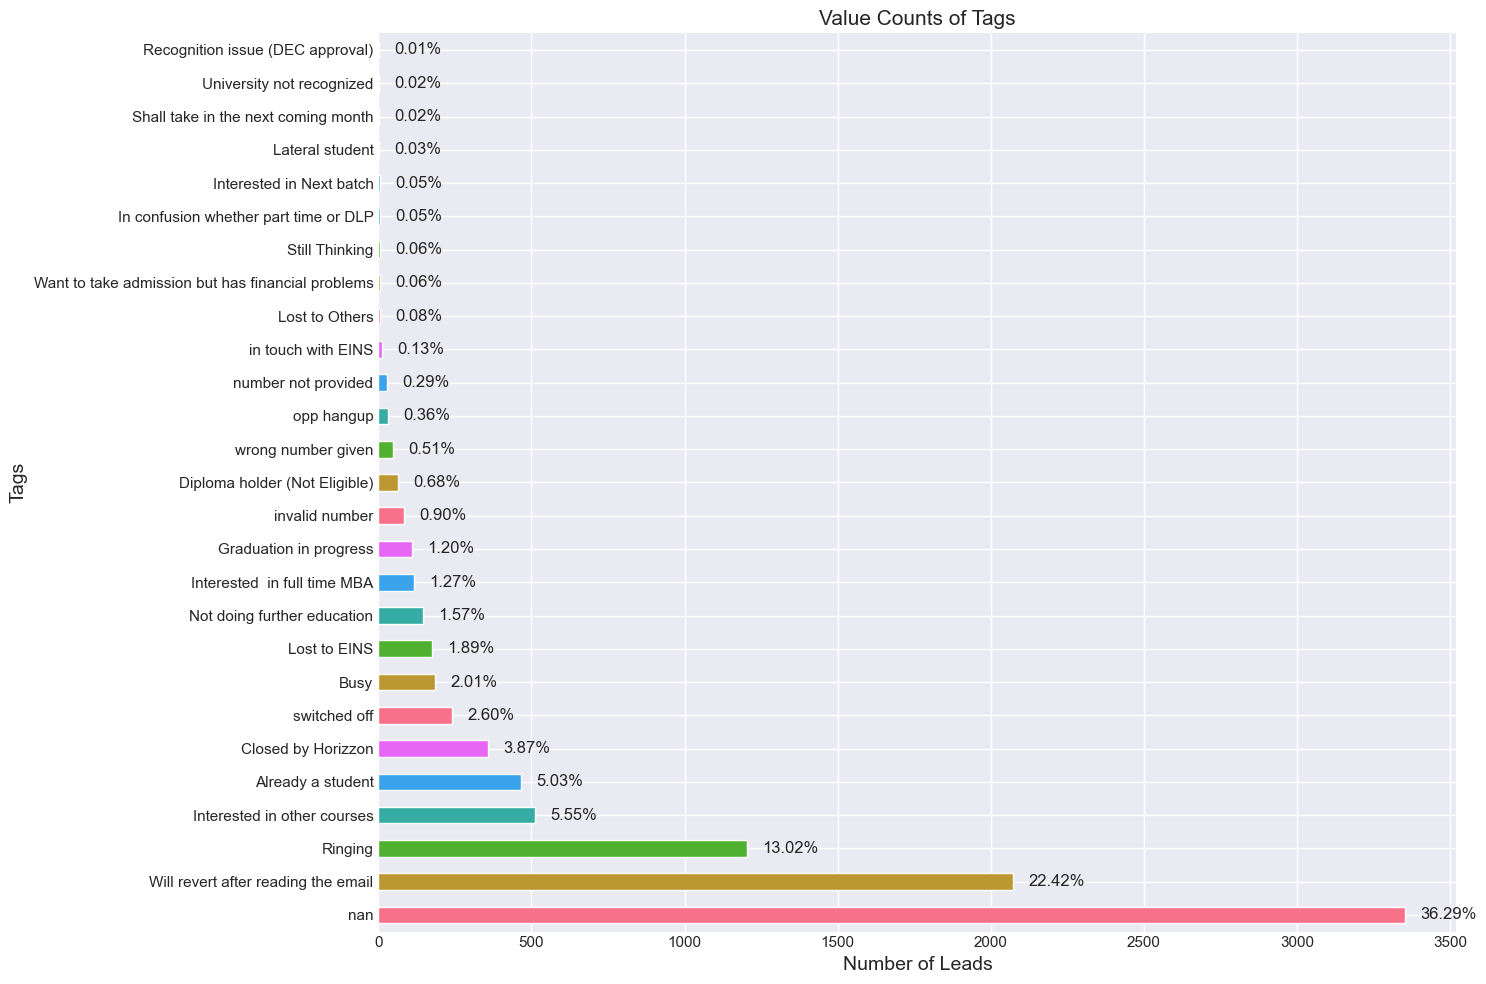

In [15]:
palette = sns.color_palette("husl") 

# Checking value counts of "Tags" column
tags_counts = leads_df['Tags'].value_counts(dropna=False)

# Calculate percentages
tags_percent = (tags_counts / tags_counts.sum()) * 100

# Plotting the value counts of Tags
plt.figure(figsize=(15, 10))
ax = tags_counts.plot(kind='barh', color=palette)

# Adding labels and title
plt.xlabel('Number of Leads', fontsize=14)
plt.ylabel('Tags', fontsize=14)
plt.title('Value Counts of Tags', fontsize=15)

# Annotating the bars with percentages
for i, v in enumerate(tags_counts):
    plt.text(v + 50, i, f'{tags_percent[i]:.2f}%', va='center', fontsize=12) 

# Show the plot
plt.tight_layout()
plt.show()


##### Tags have lot of missing values and lot of categories which will not provide useful information. 

In [16]:
# Dropping Tags as it is not going to give useful information for the analysis
# As per our reading of the data dictionary this is the response after a Sales person has already reach out to customer

leads_df = leads_df.drop('Tags', axis=1)

Now, need to visualize the features with Select values to handle Select Values

In [17]:
# finding column names in which 'Select' level is available:-

cols = list(leads.columns)
for col in cols:
    if 'Select' in leads[col].values:
        print(col)

Specialization
How did you hear about X Education
Lead Profile
City


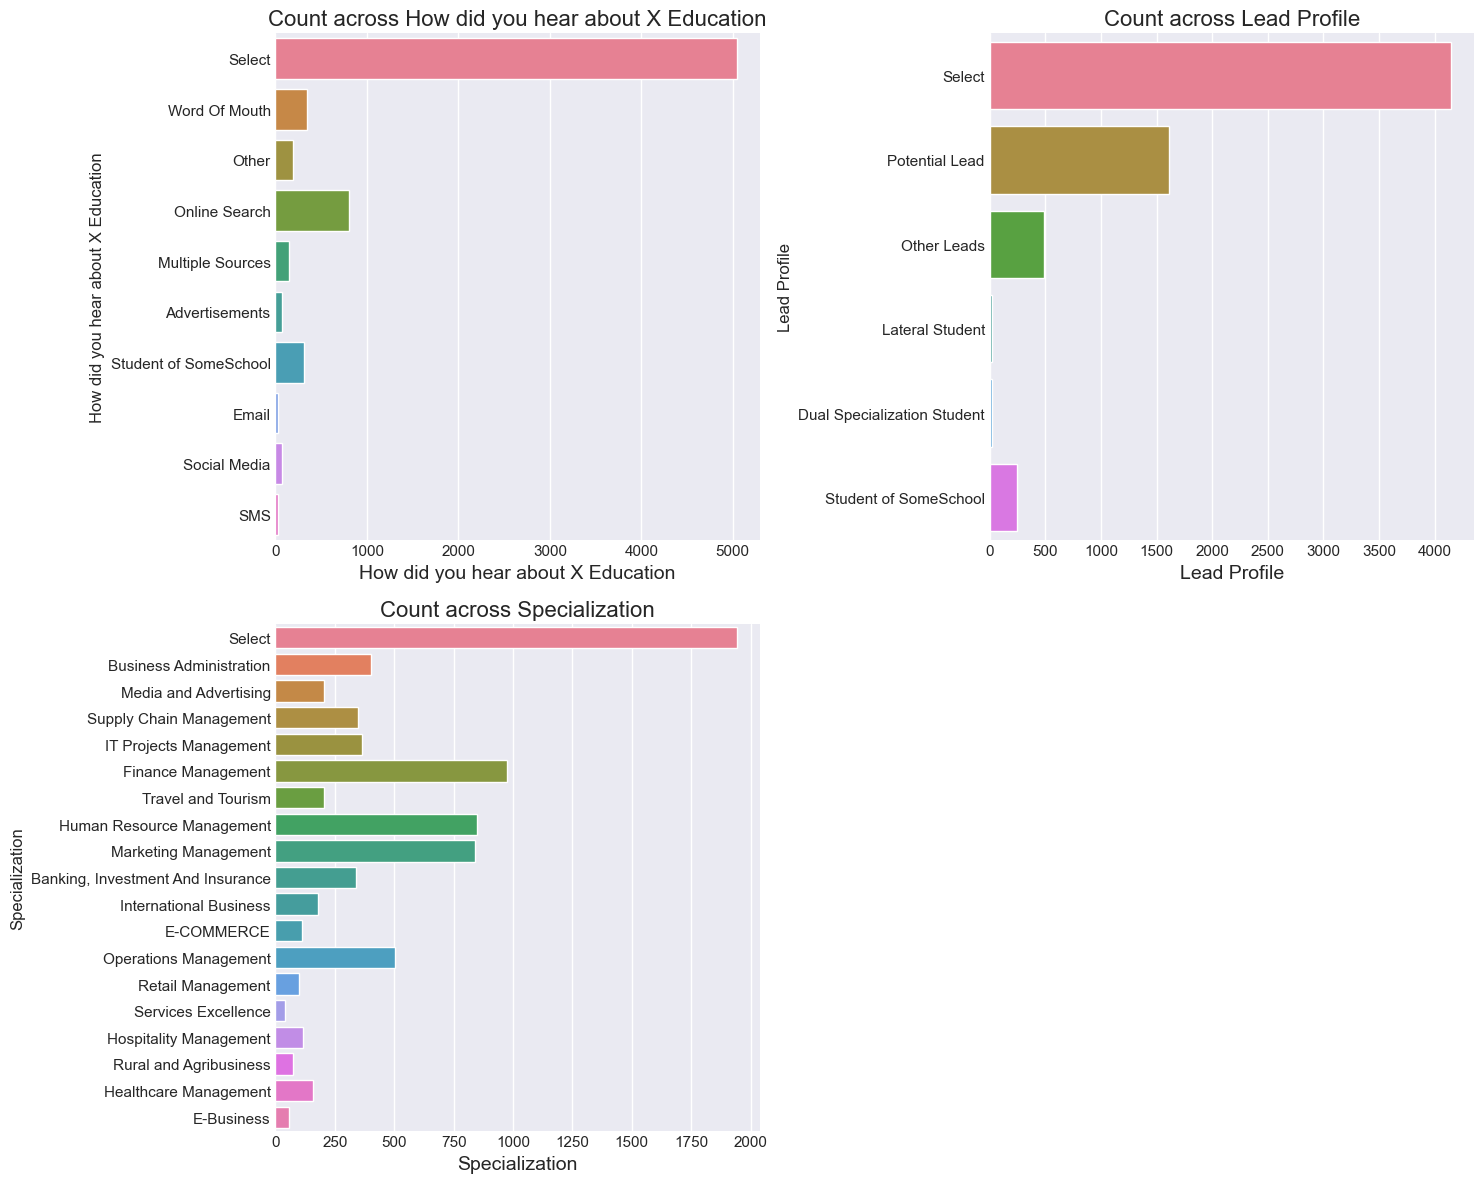

In [18]:
def countplot(x, fig):
    plt.subplot(2, 2, fig)
    sns.countplot(leads[x], palette="husl")  # Using the default seaborn color palette
    plt.title('Count across ' + x, size=16)
    plt.xlabel(x, size=14)
    #plt.xticks(rotation=90)

plt.figure(figsize=(15, 12))

countplot('How did you hear about X Education', 1)
countplot('Lead Profile', 2)
countplot('Specialization', 3)

plt.tight_layout()
plt.show()

##### Replacing Select values with missing values.


In [19]:
# Replace 'Select' values with NaN across all relevant columns
leads_df.replace('Select', pd.NA, inplace=True)

In [20]:
#checking value counts of "City" column

city_counts=leads_df['City'].value_counts(dropna=False)
city_counts

City
Mumbai                         3222
<NA>                           2249
NaN                            1420
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: count, dtype: int64

##### City has missing as well. Plot of City before handling missing values

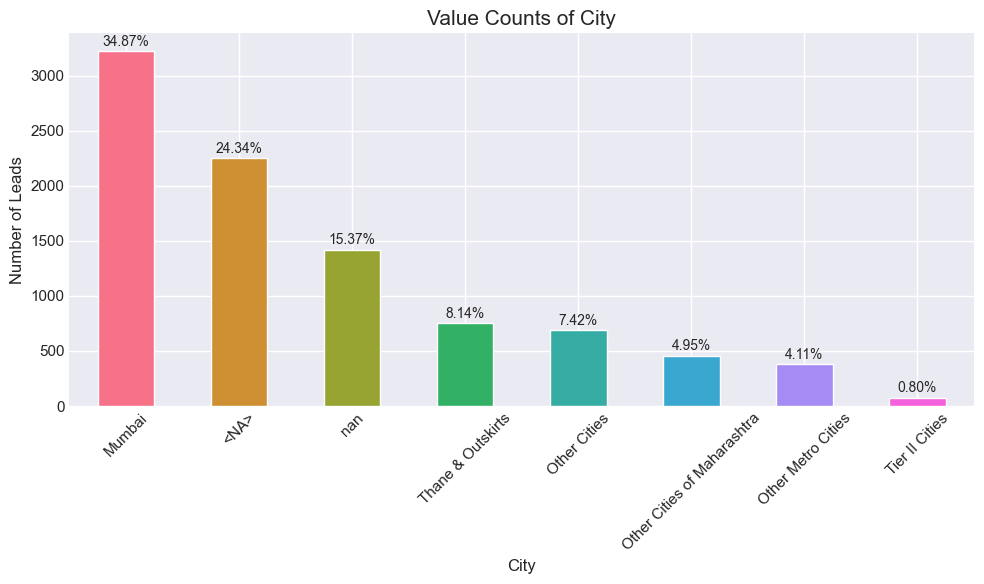

In [21]:
# Define the palette
palette = sns.color_palette("husl", len(city_counts)) 

# Plotting the value counts of city with the custom palette
plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar', color=palette)  # Use the 'palette' as the colors for the bars

# Adding labels and title
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Leads', fontsize=12)
plt.title('Value Counts of City', fontsize=15)

# Calculating percentage for each bar and adding text on top of each bar
total = city_counts.sum()
for i, value in enumerate(city_counts):
    percentage = value / total * 100
    plt.text(i, value + 50, f'{percentage:.2f}%', ha='center', fontsize=10)  # Adjust the position of the text

# Show the plot with x-ticks rotated
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1. **Mumbai** contributes the highest percentage of leads (34.87%).
2. **"Select"** and **"nan"** values make up significant portions (24.34% and 15.37%, respectively), indicating need to handle these missing values.
3. **Thane & Outskirts** and **Other Cities** contribute moderately (8.14% and 7.42%).
4. **Tier II Cities** generate the fewest leads (0.80%).
5. The large number of missing or placeholder values highlights the need for data cleaning and further analysis.

##### To handle the "Select" and "nan" (missing values) in City column,replacing them with a common category like "Unknown"

In [22]:
# Replace 'Select' with 'Unknown'
leads_df['City'] = leads_df['City'].replace('Select', 'Unknown')

# Replace NaN values with 'Unknown'
leads_df['City'] = leads_df['City'].fillna('Unknown')
leads_df['City'].value_counts()

City
Unknown                        3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: count, dtype: int64

In [23]:
show_missing(leads_df)

How did you hear about X Education               78.46
Lead Profile                                     74.19
Specialization                                   36.58
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Do Not Call                                       0.00
Prospect ID                                       0.00
Lead Number                                       0.00
Converted                                         0.00
Lead Origin                                       0.00
Total Time Spent on Website                       0.00
Do Not Email                                      0.00
Magazine                                          0.00
Search    

- **Handling the Missing Values**

- **Dropping the columns with more than 45% missing values- not useful for further analysis*

In [24]:
# Calculate the percentage of missing values for each column

missing_percentage = show_missing(leads_df)

# Identify columns with more than 45% missing values
cols_to_drop = missing_percentage[missing_percentage > 45].index

# Drop those columns from the DataFrame
leads_df = leads_df.drop(cols_to_drop, axis=1)

show_missing(leads_df)

Specialization                                   36.58
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
TotalVisits                                       1.48
Page Views Per Visit                              1.48
Last Activity                                     1.11
Lead Source                                       0.39
Lead Origin                                       0.00
Do Not Email                                      0.00
Total Time Spent on Website                       0.00
Lead Number                                       0.00
Prospect ID                                       0.00
Converted                                         0.00
Do Not Call                                       0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Educatio

In [25]:
#checking value counts of "Country" column
leads_df['Country'].value_counts(dropna=False)

Country
India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Nigeria                    4
Germany                    4
Canada                     4
Sweden                     3
Italy                      2
Belgium                    2
Ghana                      2
Philippines                2
Netherlands                2
China                      2
Asia/Pacific Region        2
Bangladesh                 2
Uganda                     2
Russia                     1
Sri Lanka                  1
Tanzania                   1
Kenya                      1
Malaysia                   1
Liberi

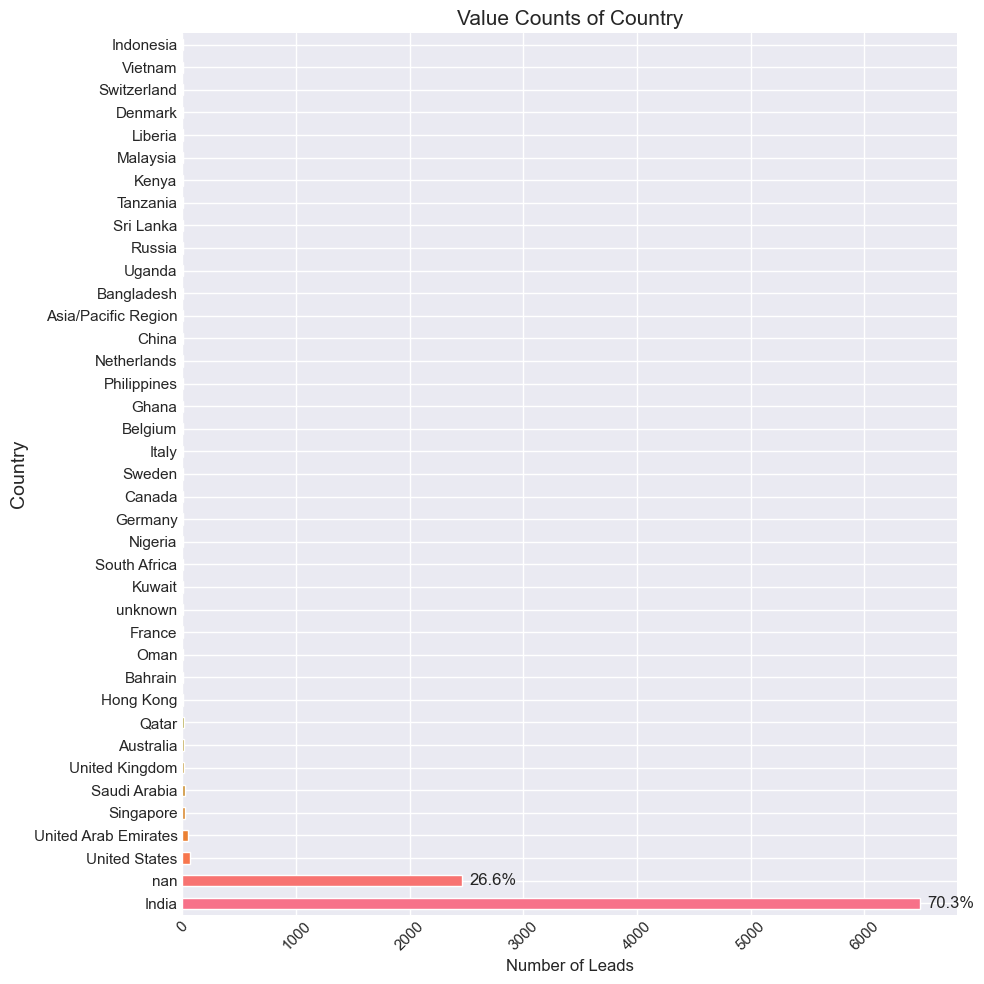

In [26]:
# Checking value counts of "Country" column
country_counts = leads_df['Country'].value_counts(dropna=False)

# Plotting the value counts of country
plt.figure(figsize=(10, 10))
ax = country_counts.plot(kind='barh', color=sns.color_palette("husl", len(country_counts)))

# Adding percentage values next to each bar if they exceed a certain threshold
total = len(leads['Country'])
threshold = 1.0  # Set threshold for percentage display

for p in ax.patches:
    width = p.get_width()
    percentage = 100 * width / total
    if percentage >= threshold:  # Only display percentage if above the threshold
        ax.annotate(f'{percentage:.1f}%', 
                    (width, p.get_y() + p.get_height() / 2), 
                    ha='left', va='center', xytext=(5, 0), 
                    textcoords='offset points', fontsize=12)

# Adding labels and title
plt.xlabel('Number of Leads', fontsize=12)
plt.ylabel('Country', fontsize=14)
plt.title('Value Counts of Country', fontsize=15)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- The vast majority of leads are from **India** (70.3%).
- A significant portion of the data is missing (26.6% marked as `NaN`).
- Given the dominance of leads from India, one option for imputing missing values is to assign them to **India**.
- However, we have decided to imputing missing values with **'unknown'** as there's uncertainty about the actual country of origin for the missing entries.
- Along with this, countries with less than 2% leads can be grouped together for further analysis

In [27]:
# Impute missing values in the 'Country' column with 'unknown_country'
leads_df['Country'] = leads_df['Country'].fillna('unknown_country')

# Get the count of each unique value in the 'Country' column
country_counts = leads_df['Country'].value_counts()
country_counts

Country
India                   6492
unknown_country         2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Nigeria                    4
Germany                    4
Canada                     4
Sweden                     3
Italy                      2
Belgium                    2
Ghana                      2
Philippines                2
Netherlands                2
China                      2
Asia/Pacific Region        2
Bangladesh                 2
Uganda                     2
Russia                     1
Sri Lanka                  1
Tanzania                   1
Kenya                      1
Malaysia                   1
Liberi

In [28]:
show_missing(leads_df)

Specialization                                   36.58
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
TotalVisits                                       1.48
Page Views Per Visit                              1.48
Last Activity                                     1.11
Lead Source                                       0.39
Do Not Email                                      0.00
Lead Origin                                       0.00
Total Time Spent on Website                       0.00
Converted                                         0.00
Lead Number                                       0.00
Prospect ID                                       0.00
Country                                           0.00
Do Not Call                                       0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Educatio

In [29]:
# creating new category 'Others' to replace null values in Specialization
leads_df['Specialization'] = leads_df['Specialization'].fillna('others')


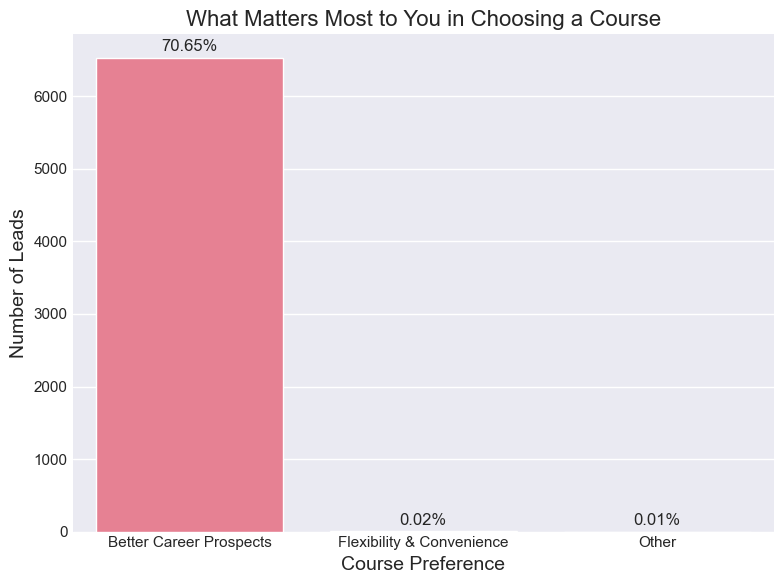

In [30]:
# Handling null values in 'What matters most to you in choosing a course'

# Value counts with percentage
course_counts = leads_df['What matters most to you in choosing a course'].value_counts(dropna=False)
total = len(leads_df['What matters most to you in choosing a course'])

# Plotting with 'husl' palette
plt.figure(figsize=(8, 6))
sns.countplot(x=leads_df['What matters most to you in choosing a course'], palette='husl')

# Adding percentages above each bar
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 8), textcoords='offset points')

# Adding labels and title
plt.title('What Matters Most to You in Choosing a Course', size=16)
plt.xlabel('Course Preference', size=14)
plt.ylabel('Number of Leads', size=14)

plt.tight_layout()
plt.show()

In [31]:
# Replacing null values with 'Other'
leads_df['What matters most to you in choosing a course'] = leads_df['What matters most to you in choosing a course'].replace(np.nan, 'Other')

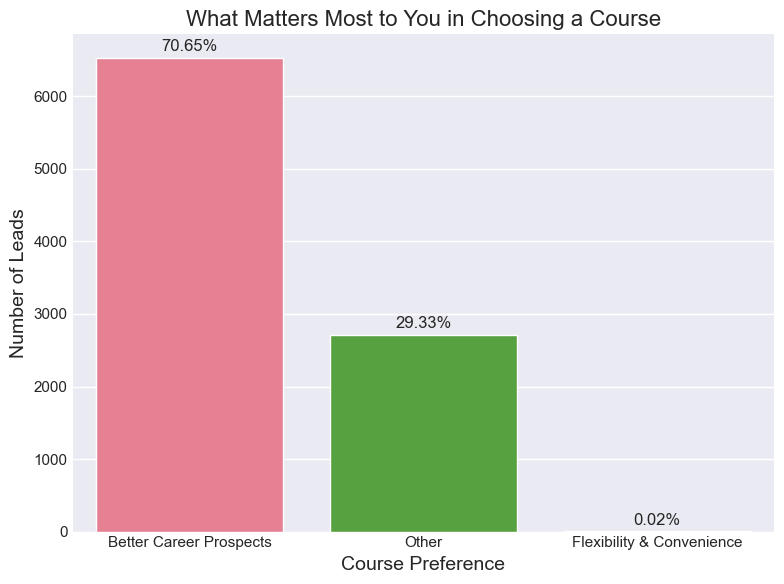

In [32]:
# Handling null values in 'What matters most to you in choosing a course'

# Value counts with percentage
course_counts = leads_df['What matters most to you in choosing a course'].value_counts(dropna=False)
total = len(leads_df['What matters most to you in choosing a course'])

# Plotting with 'husl' palette
plt.figure(figsize=(8, 6))
sns.countplot(x=leads_df['What matters most to you in choosing a course'], palette='husl')

# Adding percentages above each bar
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 8), textcoords='offset points')

# Adding labels and title
plt.title('What Matters Most to You in Choosing a Course', size=16)
plt.xlabel('Course Preference', size=14)
plt.ylabel('Number of Leads', size=14)

plt.tight_layout()
plt.show()

# Replacing null values with 'Other'
leads['What matters most to you in choosing a course'] = leads['What matters most to you in choosing a course'].replace(np.nan, 'Other')

- The majority of respondents (70.65%) prioritize "Better Career Prospects" when choosing a course.
- Around 29.33% of leads selected "Other" as the reason for their course preference.
- A very small percentage (0.02%) considered "Flexibility & Convenience" as their primary factor in course selection.
- This suggests that career advancement is a key driver for most leads when making educational decisions.

In [33]:
# Checking missing or null values again to verify in percentage format
show_missing(leads_df)

What is your current occupation                  29.11
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Do Not Email                                      0.00
Lead Origin                                       0.00
Lead Number                                       0.00
Do Not Call                                       0.00
Total Time Spent on Website                       0.00
Converted                                         0.00
Country                                           0.00
Prospect ID                                       0.00
Specialization                                    0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Educatio

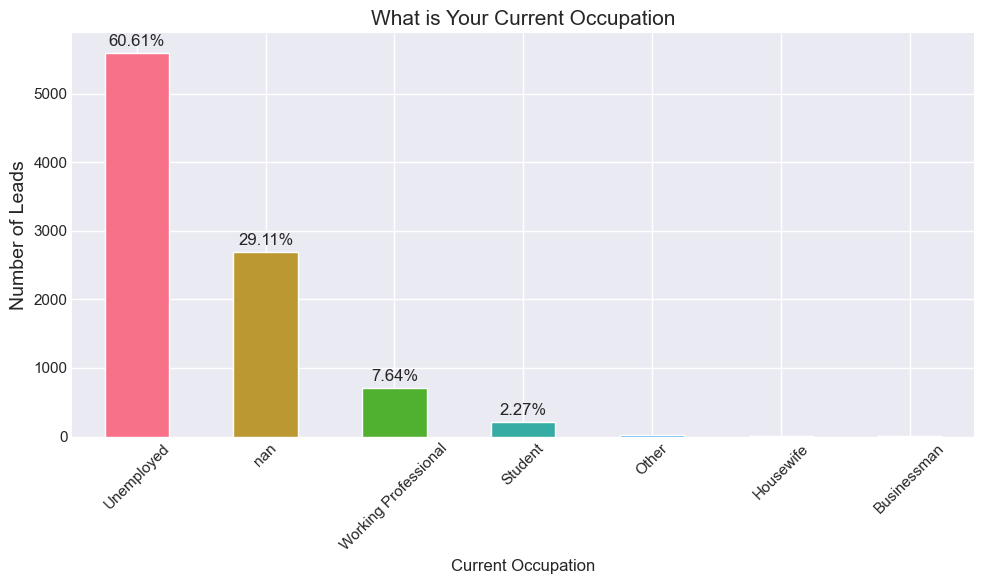

In [34]:
# Handling null values in 'What is your current occupation'
occupation_counts = leads_df['What is your current occupation'].value_counts(dropna=False)

# Plotting the value counts of 'What is your current occupation'
plt.figure(figsize=(10, 6))
palette = sns.color_palette("husl")
occupation_counts.plot(kind='bar', color=palette)

# Adding percentage labels above each bar
total_leads = len(leads['What is your current occupation'])
for i, count in enumerate(occupation_counts):
    percentage = (count / total_leads) * 100
    if percentage > 1:  # Display percentage only if greater than 1%
        plt.text(i, count + 100, f'{percentage:.2f}%', ha='center', fontsize=12)

# Adding labels and title
plt.xlabel('Current Occupation', fontsize=12)
plt.ylabel('Number of Leads', fontsize=14)
plt.title('What is Your Current Occupation', fontsize=15)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [35]:
# replace null values with other

leads_df['What is your current occupation'] = leads_df['What is your current occupation'].replace(np.nan, 'Other')

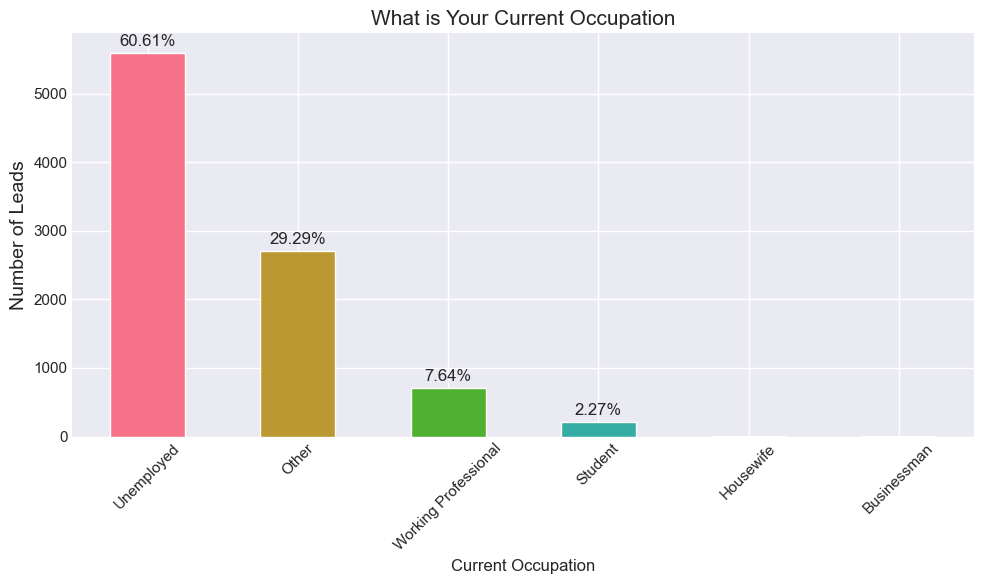

In [36]:
# Handling null values in 'What is your current occupation'
occupation_counts = leads_df['What is your current occupation'].value_counts(dropna=False)

# Plotting the value counts of 'What is your current occupation'
plt.figure(figsize=(10, 6))
palette = sns.color_palette("husl")
occupation_counts.plot(kind='bar', color=palette)

# Adding percentage labels above each bar
total_leads = len(leads_df['What is your current occupation'])
for i, count in enumerate(occupation_counts):
    percentage = (count / total_leads) * 100
    if percentage > 1:  # Display percentage only if greater than 1%
        plt.text(i, count + 100, f'{percentage:.2f}%', ha='center', fontsize=12)

# Adding labels and title
plt.xlabel('Current Occupation', fontsize=12)
plt.ylabel('Number of Leads', fontsize=14)
plt.title('What is Your Current Occupation', fontsize=15)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
show_missing(leads_df)

TotalVisits                                      1.48
Page Views Per Visit                             1.48
Last Activity                                    1.11
Lead Source                                      0.39
Prospect ID                                      0.00
Do Not Email                                     0.00
Lead Origin                                      0.00
Lead Number                                      0.00
Do Not Call                                      0.00
Total Time Spent on Website                      0.00
Converted                                        0.00
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Magazine                                         0.00
Newspaper Article                                0.00
X Education Forums          

- **Next step- To handle the missing values in Numerical Colums** 

In [38]:
#handling the null values in numerical columns

# Replacing null values in numeric columns with 0
leads_df['TotalVisits'] = leads_df['TotalVisits'].replace(np.nan, 0)
leads_df['Page Views Per Visit'] = leads_df['Page Views Per Visit'].replace(np.nan, 0)

In [39]:
# Checking null values percentage after replacement
show_missing(leads_df)

Last Activity                                    1.11
Lead Source                                      0.39
Prospect ID                                      0.00
Lead Origin                                      0.00
Lead Number                                      0.00
Do Not Email                                     0.00
Do Not Call                                      0.00
TotalVisits                                      0.00
Converted                                        0.00
Total Time Spent on Website                      0.00
Page Views Per Visit                             0.00
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Magazine                                         0.00
Newspaper Article                                0.00
X Education Forums          

In [40]:
# Exploring the null values in Last Activity
print(leads['Last Activity'].value_counts(dropna=False))

Last Activity
Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
NaN                              103
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: count, dtype: int64


In [41]:
# Imputing the null values with a new category 'Unknown'
leads_df['Last Activity'] = leads_df['Last Activity'].replace(np.nan, 'Unknown')

# Checking null values percentage after replacement
show_missing(leads_df)

Lead Source                                      0.39
Prospect ID                                      0.00
Lead Number                                      0.00
Lead Origin                                      0.00
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      0.00
Total Time Spent on Website                      0.00
Page Views Per Visit                             0.00
Last Activity                                    0.00
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Magazine                                         0.00
Newspaper Article                                0.00
X Education Forums          

In [42]:
# Exploring the next highest null value: Lead Source
print(leads_df['Lead Source'].value_counts(dropna=False))

Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Live Chat               2
Social Media            2
Press_Release           2
Pay per Click Ads       1
blog                    1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
testone                 1
NC_EDM                  1
Name: count, dtype: int64


- **replace the missing values with unknown**
- **Google** and **google** are counted separately.
- **Need to handle this before plotting the graph**

In [43]:
# Imputing the null values with a new category 'Unknown'
leads_df['Lead Source'] = leads_df['Lead Source'].replace(np.nan, 'Unknown')

# Normalize the 'Lead Source' column by converting all values to lowercase
leads_df['Lead Source'] = leads_df['Lead Source'].str.lower().str.strip()

# Checking if 'google' still exists after replacement (debugging step)
leads_df['Lead Source'].value_counts()

Lead Source
google               2873
direct traffic       2543
olark chat           1755
organic search       1154
reference             534
welingak website      142
referral sites        125
facebook               55
unknown                36
bing                    6
click2call              4
live chat               2
social media            2
press_release           2
pay per click ads       1
blog                    1
welearn                 1
welearnblog_home        1
youtubechannel          1
testone                 1
nc_edm                  1
Name: count, dtype: int64

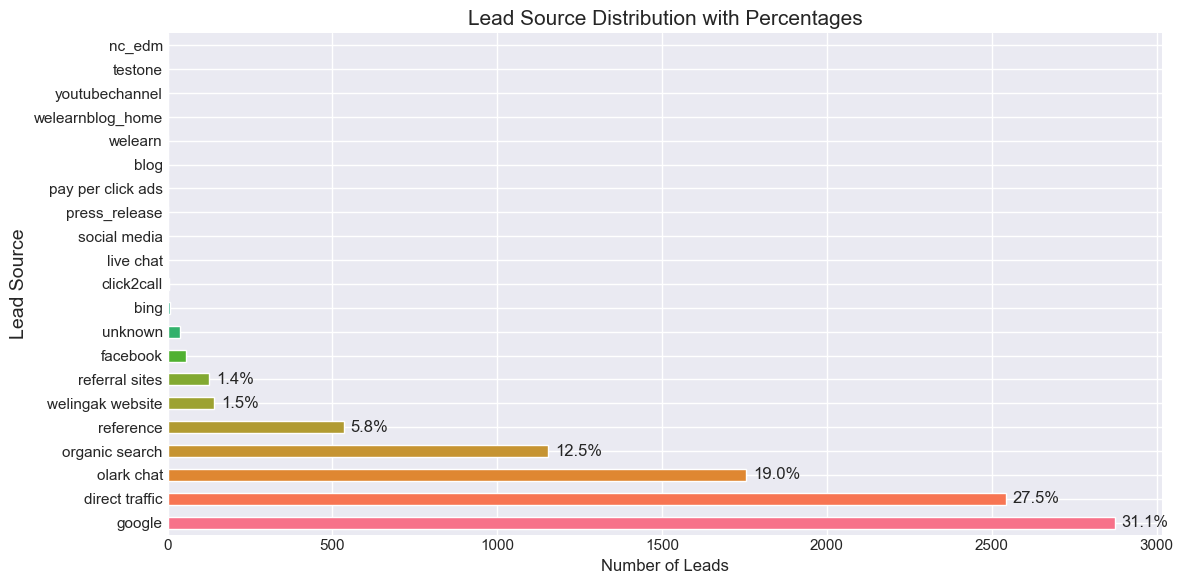

In [44]:
# Checking value counts of "Lead Source" column
lead_source_counts = leads_df['Lead Source'].value_counts(dropna=False)

# Plotting the value counts of Lead Source
plt.figure(figsize=(12, 6))
ax = lead_source_counts.plot(kind='barh', color=sns.color_palette("husl", len(lead_source_counts)))

# Adding percentage values next to each bar having values higher than threshold
total = len(leads_df['Lead Source'])
threshold = 1.0  # Set threshold for percentage display

for p in ax.patches:
    width = p.get_width()
    percentage = 100 * width / total
    if percentage >= threshold:  # Only display percentage if above the threshold
        ax.annotate(f'{percentage:.1f}%', 
                    (width, p.get_y() + p.get_height() / 2), 
                    ha='left', va='center', xytext=(5, 0), 
                    textcoords='offset points', fontsize=12)

# Adding labels and title
plt.xlabel('Number of Leads', fontsize=12)
plt.ylabel('Lead Source', fontsize=14)
plt.title('Lead Source Distribution with Percentages', fontsize=15)

# Show the plot
plt.tight_layout()
plt.show()


- The top lead source is **Google**, accounting for 31.1% of the total leads.
- **Direct Traffic** is the second largest source, contributing 27.5% of the leads.
- **Organic Search** accounts for 19%, and **Reference** makes up 12.5%.
- All other sources (such as **Facebook**, **Referral Sites**, and **Welingak Website**) contribute less than 6% each.
- Some lead sources like **nc_edm**, **testone**, and **youtubechannel** have negligible contributions.

**Checking the missing values again**

In [45]:
# Checking null values percentage after replacement
show_missing(leads_df)

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                            

#### All the missing values are handled, next is EDA analysis!

## EDA

### Univariate Analysis


In [46]:
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 29 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9240 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9240 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9240 

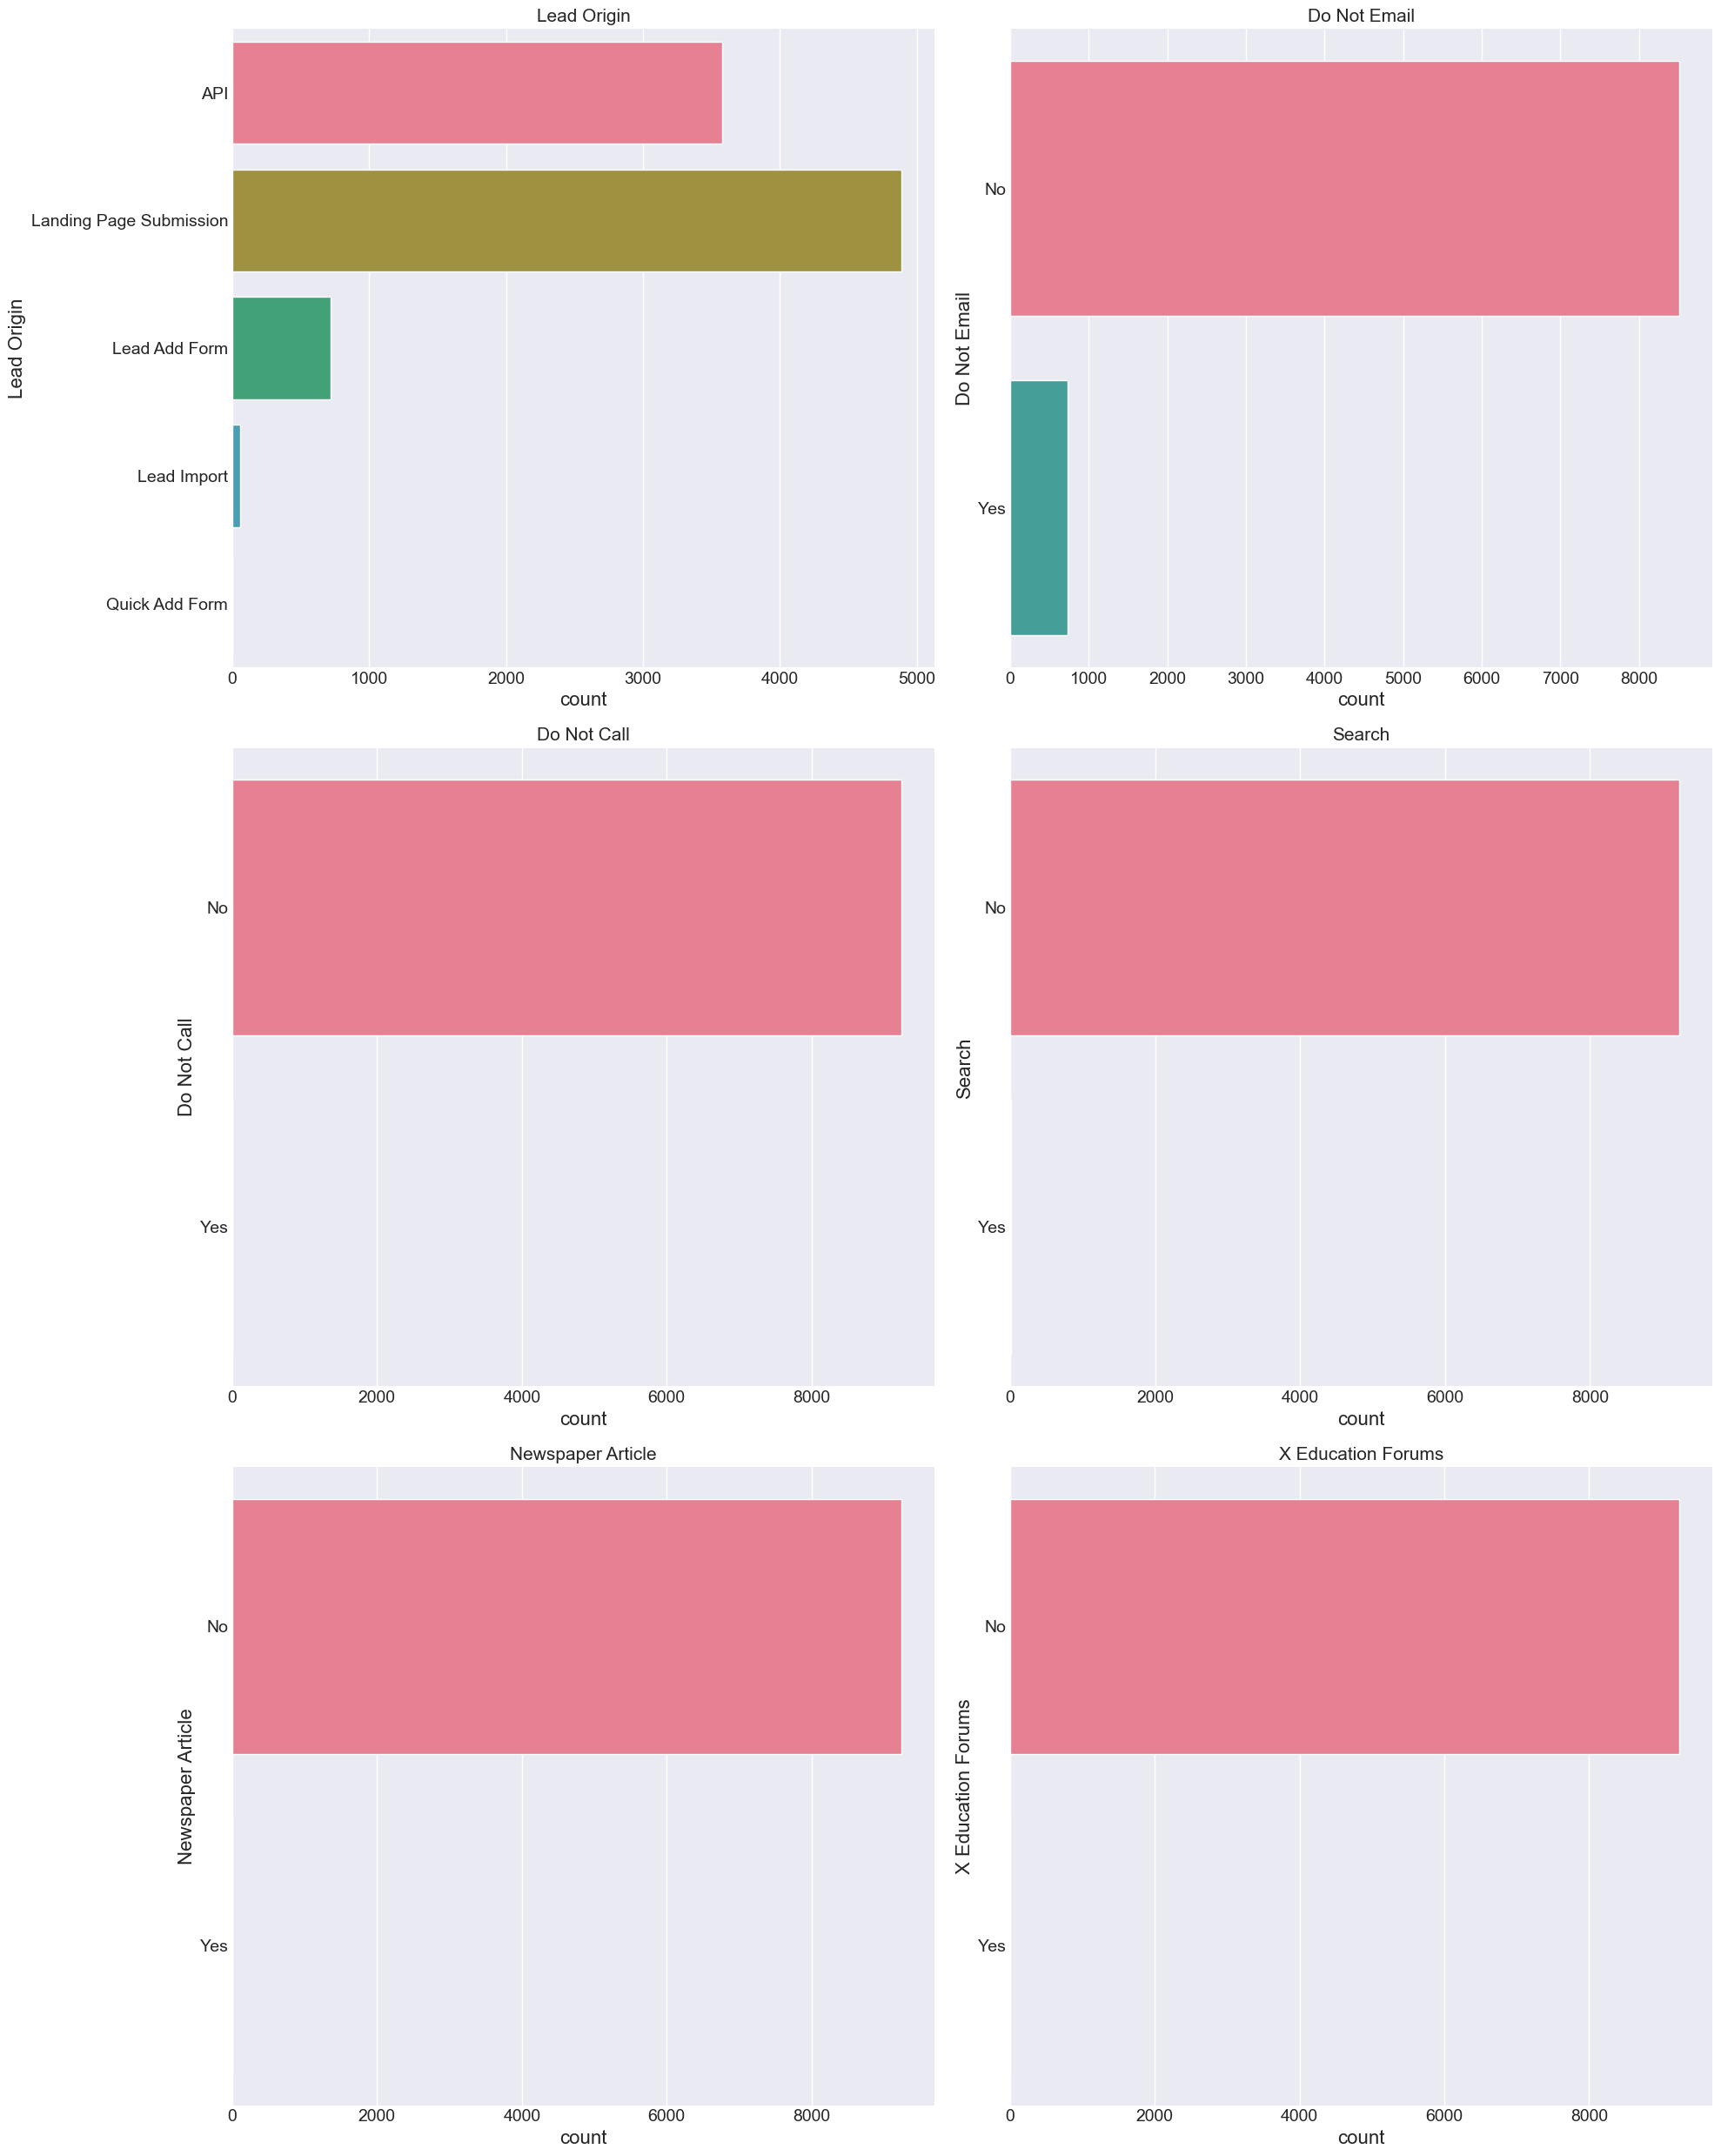

In [47]:
palette = 'husl' 

plt.rc('font', size=14)          # font size for text
plt.rc('axes', titlesize=15)     # font size for subplot titles
plt.rc('axes', labelsize=16)     # font size for axis labels
plt.rc('xtick', labelsize=14)    # font size for x-tick labels
plt.rc('ytick', labelsize=14)    # font size for y-tick labels
plt.rc('legend', fontsize=16)    # font size for legend
plt.rc('figure', titlesize=24)   # font size for figure title

plt.figure(figsize=(20, 25))  # Adjust figure size for 6 subplots

# Subplot 1: Lead Origin
plt.subplot(3, 2, 1)
sns.countplot(y=leads_df['Lead Origin'], palette=palette)  # Using the same palette
plt.title('Lead Origin')

# Subplot 2: Do Not Email
plt.subplot(3, 2, 2)
sns.countplot(leads_df['Do Not Email'], palette=palette)  # Using the same palette
plt.title('Do Not Email')

# Subplot 3: Do Not Call
plt.subplot(3, 2, 3)
sns.countplot(leads_df['Do Not Call'], palette=palette)  # Using the same palette
plt.title('Do Not Call')

# Subplot 4: Search
plt.subplot(3, 2, 4)
sns.countplot(leads['Search'], palette=palette)  # Using the same palette
plt.title('Search')

# Subplot 5: Newspaper Article
plt.subplot(3, 2, 5)
sns.countplot(leads['Newspaper Article'], palette=palette)  # Using the same palette
plt.title('Newspaper Article')

# Subplot 6: X Education Forums
plt.subplot(3, 2, 6)
sns.countplot(leads['X Education Forums'], palette=palette)  # Using the same palette
plt.title('X Education Forums')

plt.tight_layout()
plt.show()

1. **Lead Origin**: Most leads come from **Landing Page Submissions**, with **API** also contributing significantly, while other origins are minimal.
2. **Do Not Email**: The majority of leads have opted no emails.
3. **Do Not Call**: Almost all leads have opted for no calls, indicating that the "Do Not Call" preference is overwhelmingly common.
4. **Search**: Very few leads have come from searches, suggesting this channel is underutilized or ineffective.
5. **Newspaper Article**: Leads from **Newspaper Articles** are nearly nonexistent, with most leads not exposed to this source.
6. **X Education Forums**: Similarly, leads generated through **X Education Forums** are negligible, with nearly all responses indicating no interaction with this forum.

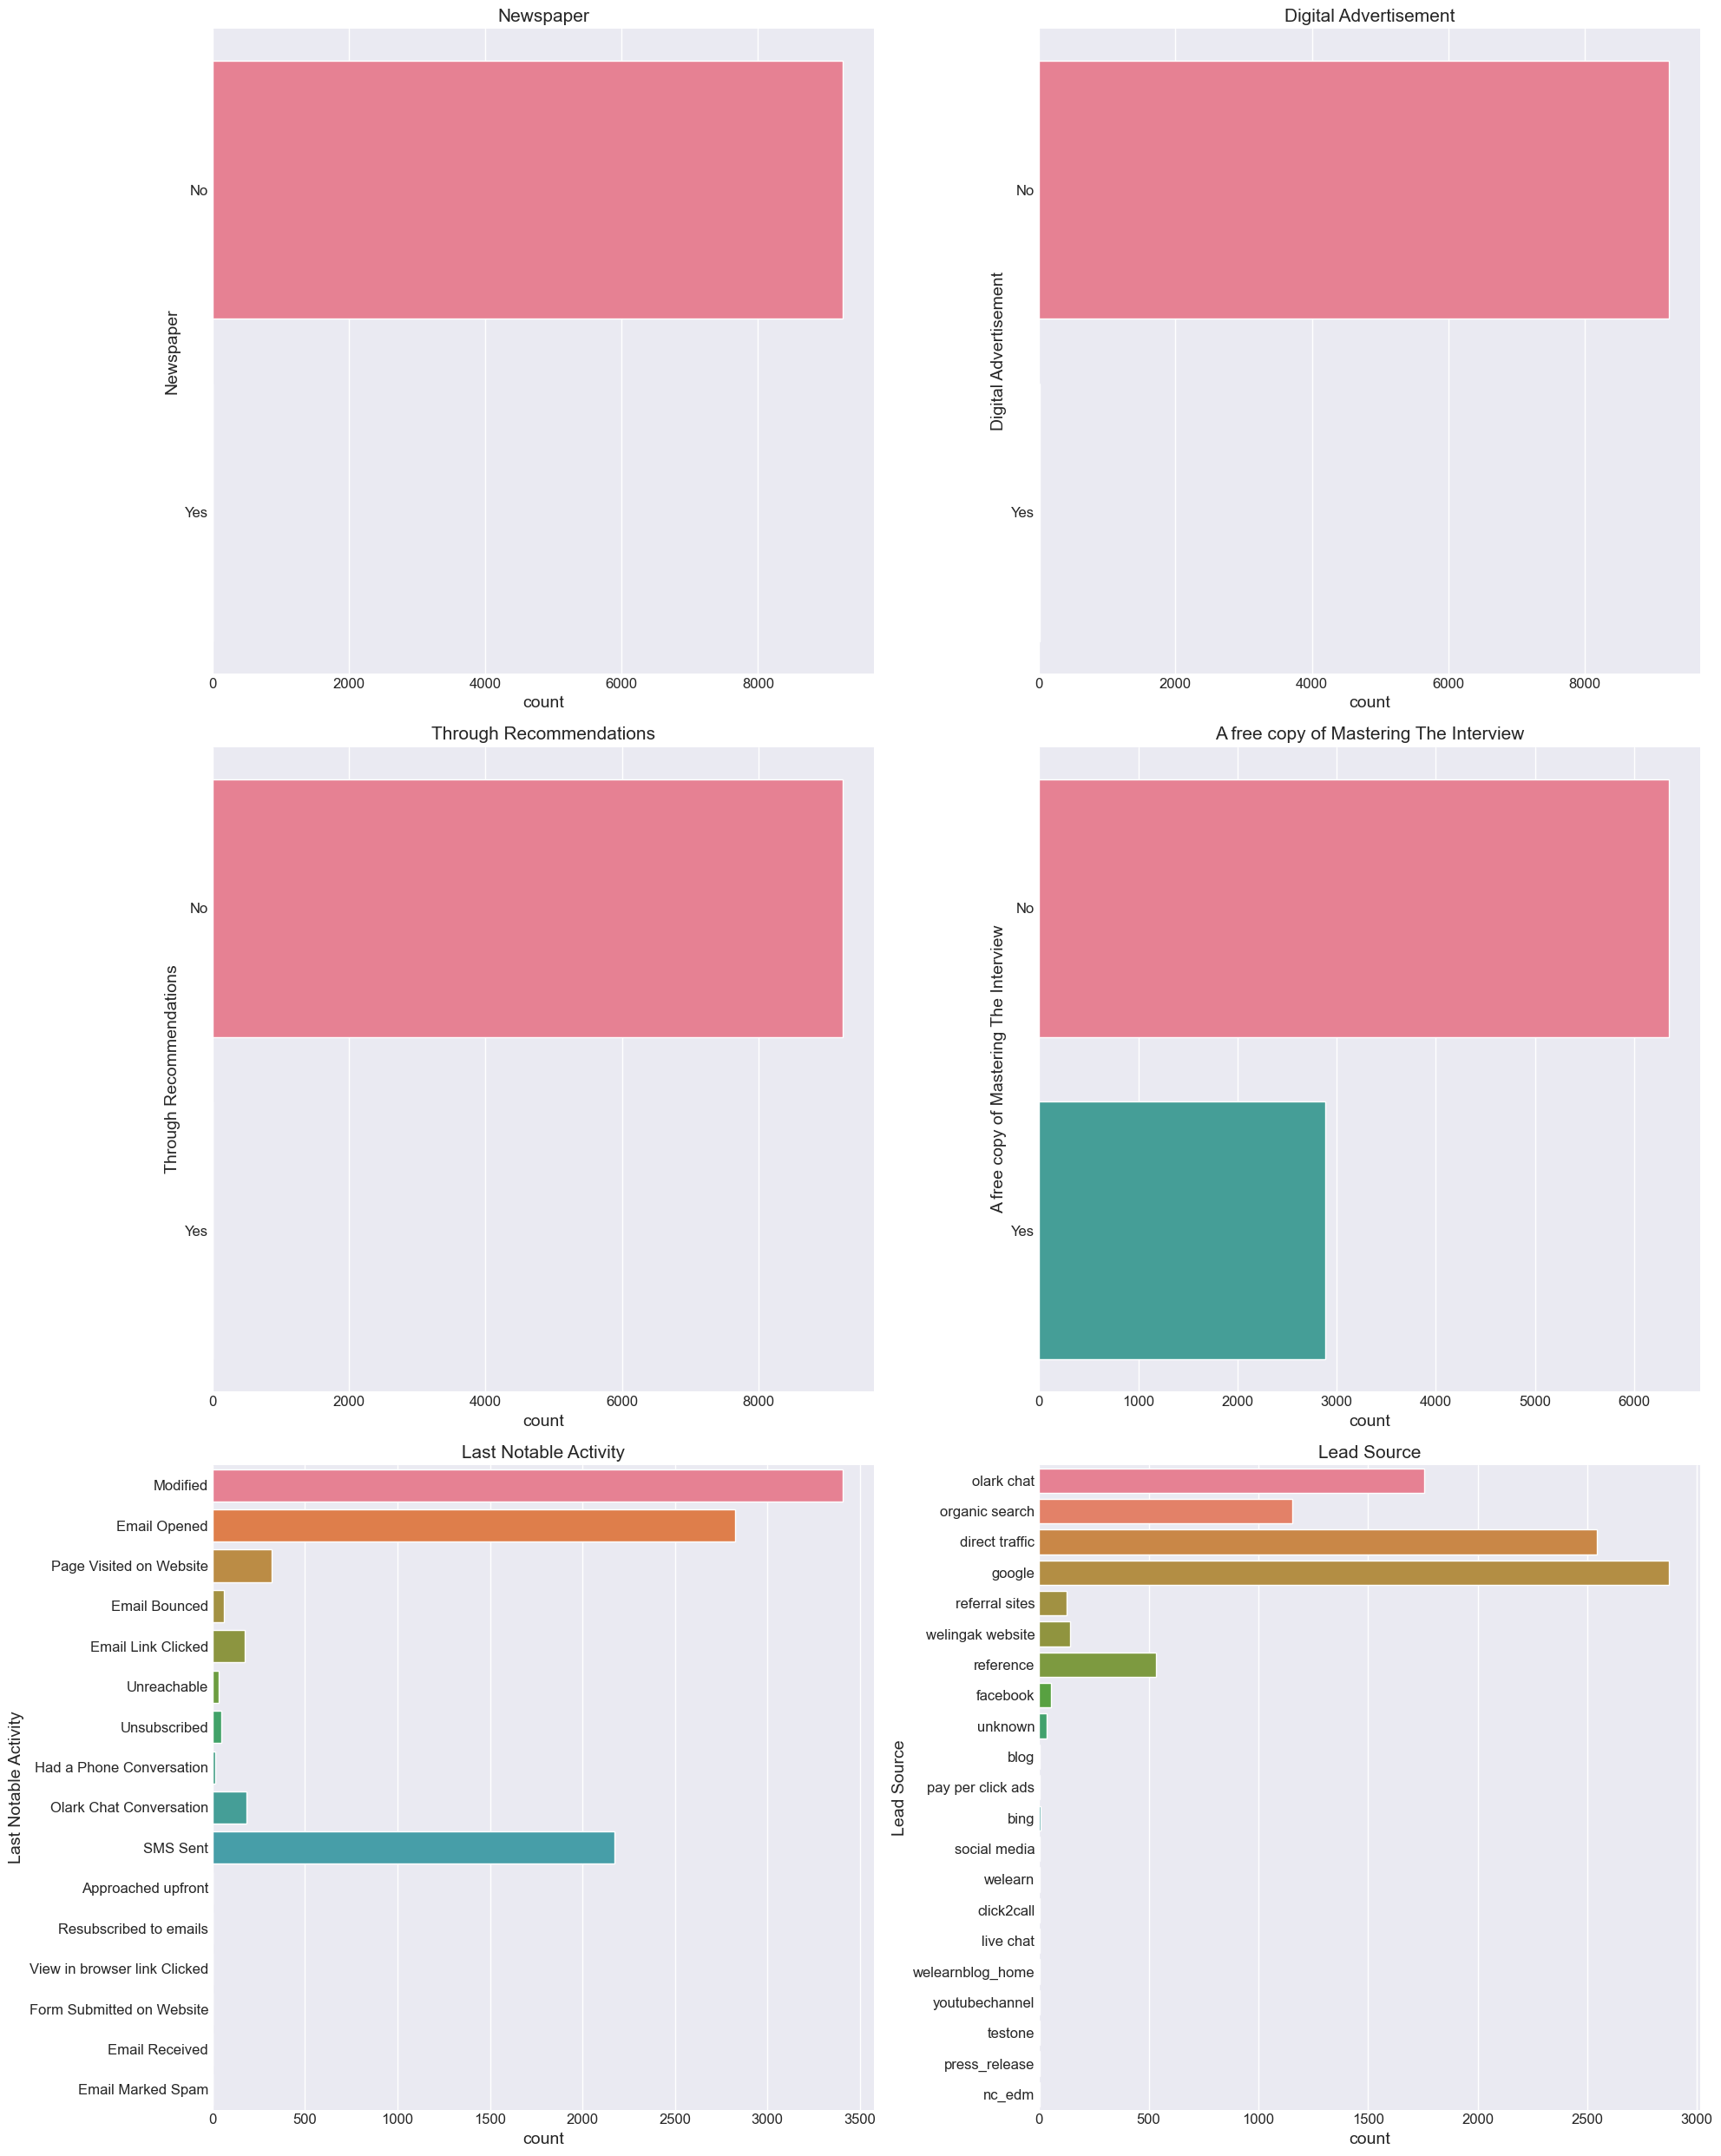

In [48]:
palette = 'husl' 

plt.rc('font', size=12)          # font size for text
plt.rc('axes', titlesize=15)     # font size for subplot titles
plt.rc('axes', labelsize=14)     # font size for axis labels
plt.rc('xtick', labelsize=12)    # font size for x-tick labels
plt.rc('ytick', labelsize=12)    # font size for y-tick labels
plt.rc('legend', fontsize=14)    # font size for legend
plt.rc('figure', titlesize=20)   # font size for figure title
plt.figure(figsize=(20, 25))  # Adjust figure size for 6 subplots

# Subplot 1: Newspaper
plt.subplot(3, 2, 1)
sns.countplot(leads_df['Newspaper'],palette=palette)
plt.title('Newspaper')

# Subplot 2: Digital Advertisement
plt.subplot(3, 2, 2)
sns.countplot(leads_df['Digital Advertisement'], palette=palette)
plt.title('Digital Advertisement')

# Subplot 3: Through Recommendations
plt.subplot(3, 2, 3)
sns.countplot(leads_df['Through Recommendations'], palette=palette)
plt.title('Through Recommendations')

# Subplot 4: A free copy of Mastering The Interview
plt.subplot(3, 2, 4)
sns.countplot(leads_df['A free copy of Mastering The Interview'], palette=palette)
plt.title('A free copy of Mastering The Interview')

# Subplot 5: Last Notable Activity (Horizontal plot for readability)
plt.subplot(3, 2, 5)
sns.countplot(y=leads_df['Last Notable Activity'], palette=palette)
plt.title('Last Notable Activity')

# Subplot 6: Lead Source (Horizontal plot for readability)
plt.subplot(3, 2, 6)
sns.countplot(y=leads_df['Lead Source'], palette=palette)
plt.title('Lead Source')

plt.tight_layout()
plt.show()


1. **Newspaper**: Leads rarely come from newspapers, indicating this is not an effective channel.
2. **Digital Advertisement**: Very few leads are generated from digital ads, suggesting low engagement from this source.
3. **Through Recommendations**: Recommendations contribute minimally to lead generation, showing limited word-of-mouth impact.
4. **A Free Copy of Mastering The Interview**: Offering free resources is effective, with many leads opting for the free copy.
5. **Last Notable Activity**: Email and SMS interactions dominate as the most frequent activities, though further engagement (e.g., form submissions) is limited.
6. **Lead Source**: Direct traffic, organic search, and live chat are the primary sources of leads, while social media and referral channels are less effective.

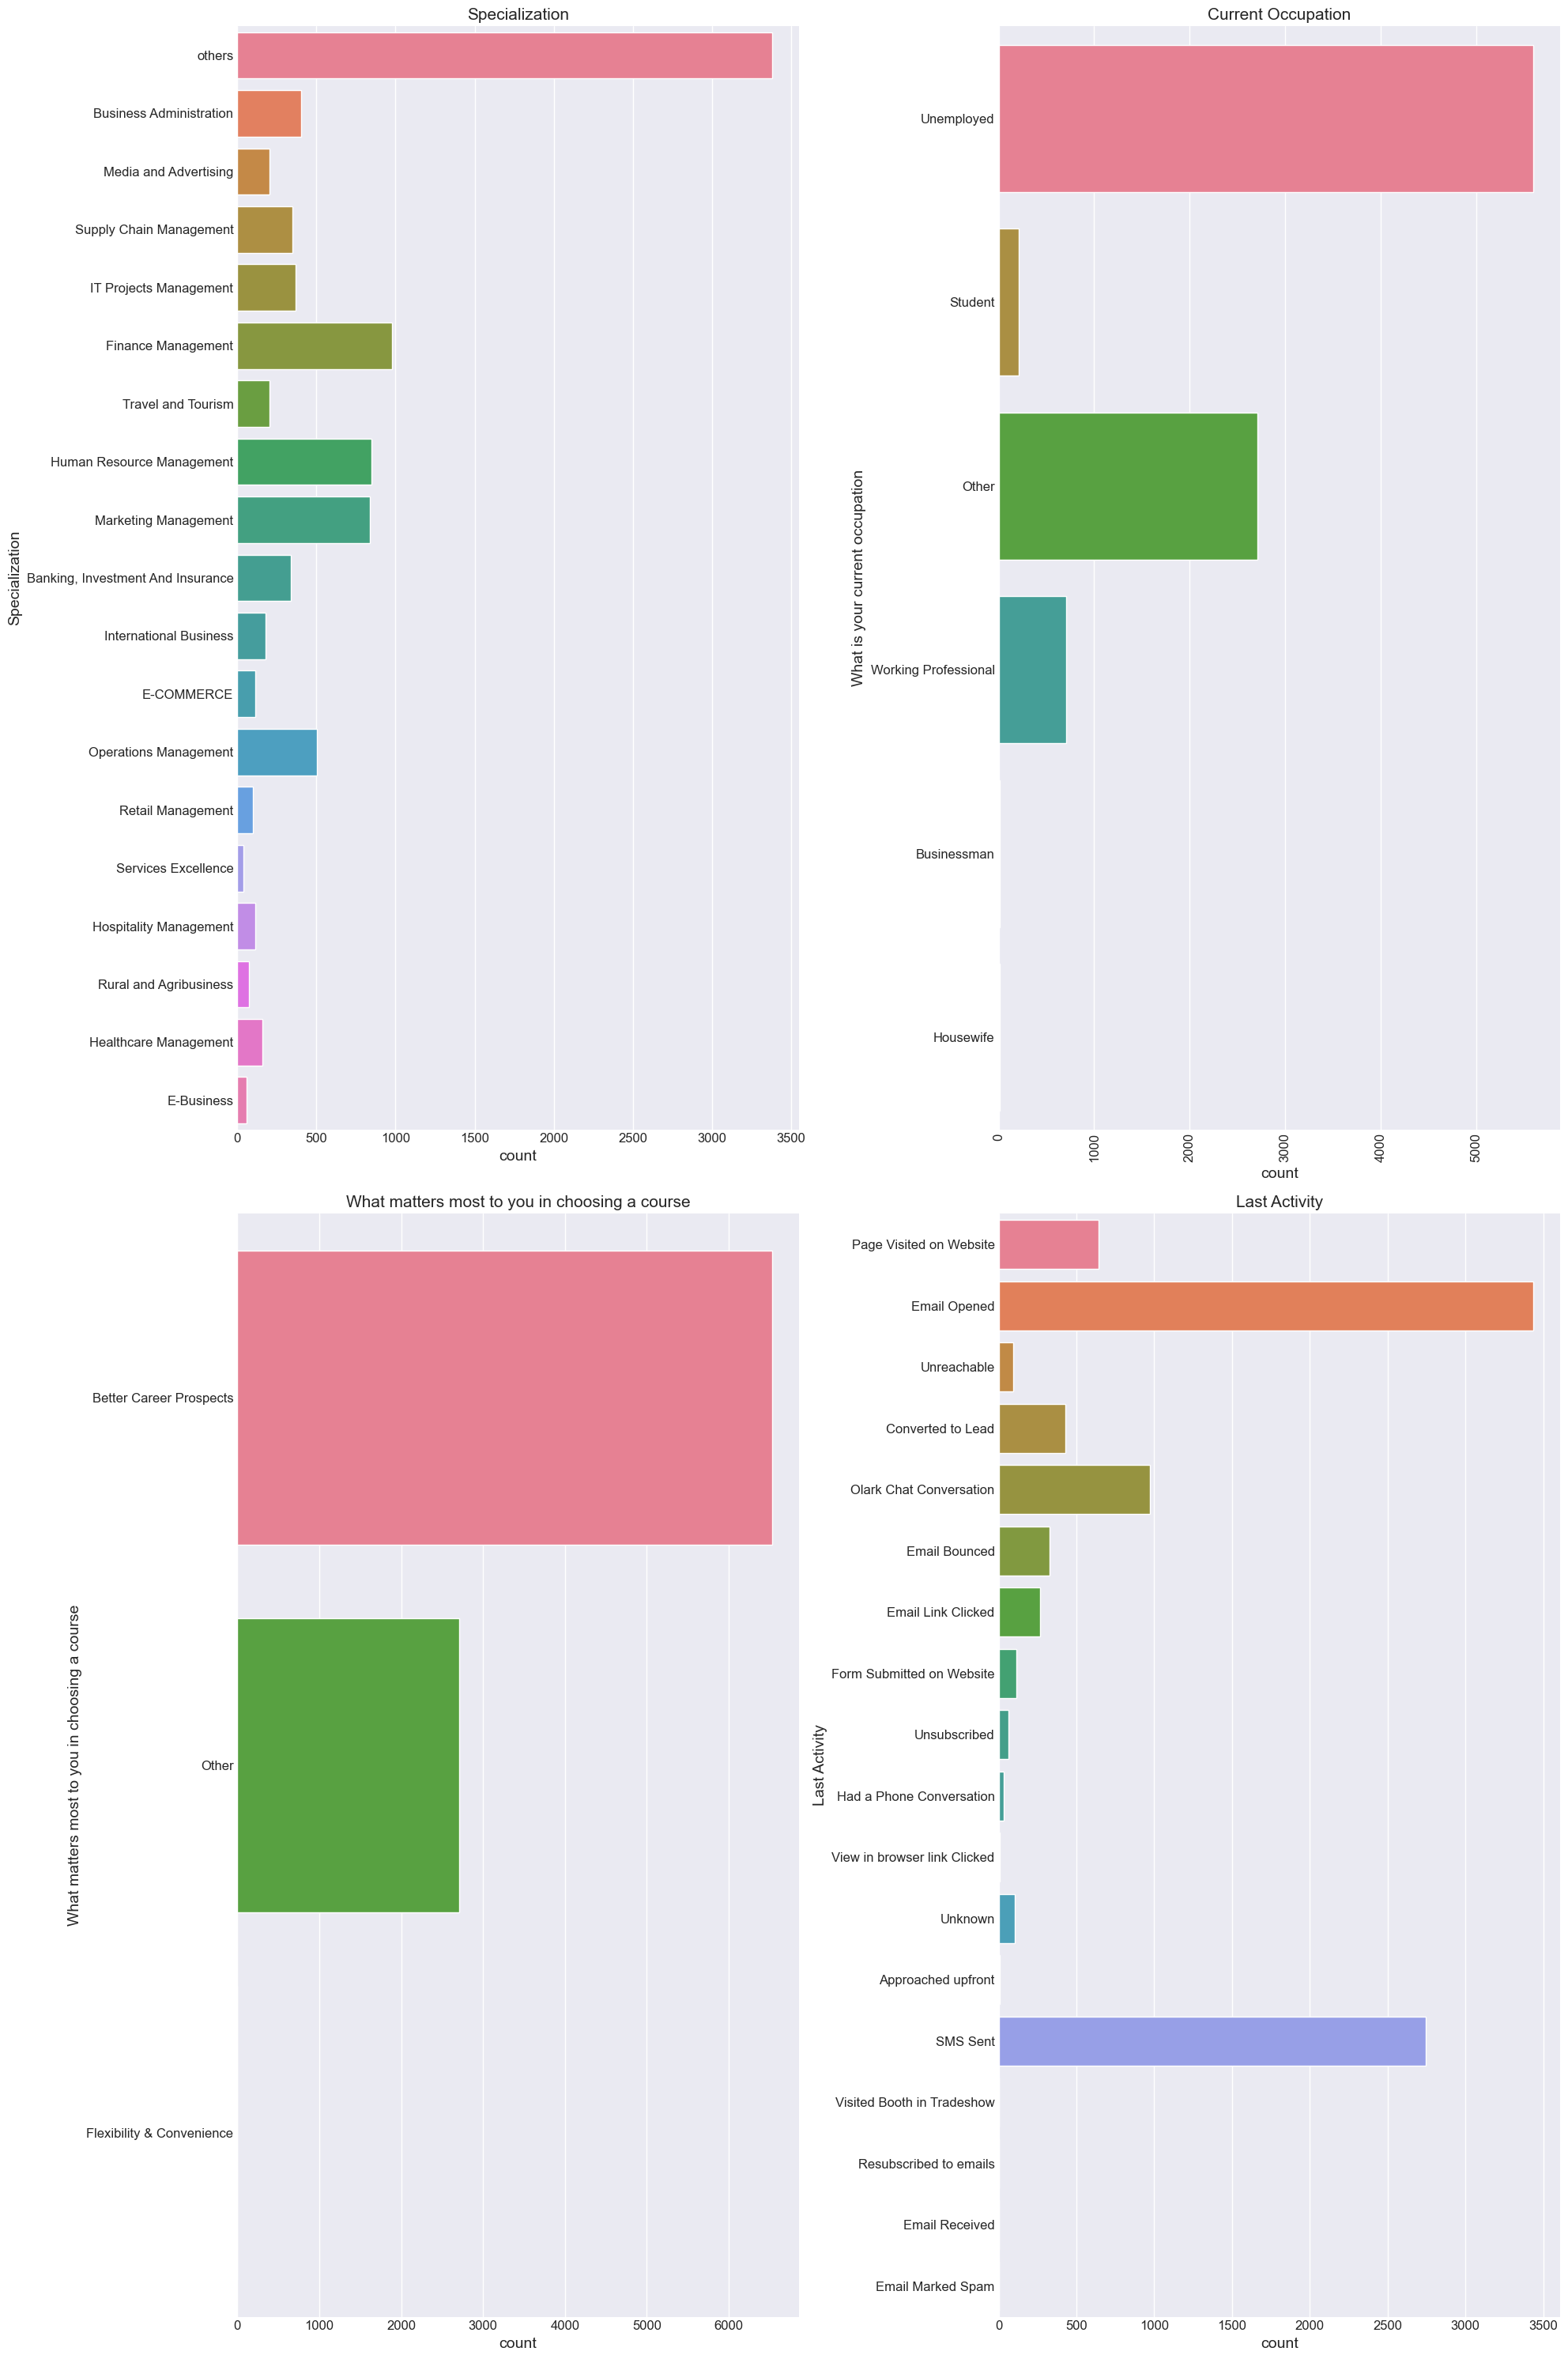

In [49]:
palette = 'husl' 

plt.figure(figsize=(20, 30))  

# Plot 1: Specialization
plt.subplot(2, 2, 1)
sns.countplot(y=leads_df['Specialization'], palette=palette).set_title('Specialization')

# Plot 2: Current Occupation 
plt.subplot(2, 2, 2)
sns.countplot(leads_df['What is your current occupation'], palette=palette).tick_params(axis='x', rotation=90)
plt.title('Current Occupation')

# Plot 3: What matters most in choosing a course
plt.subplot(2, 2, 3)
sns.countplot(y=leads_df['What matters most to you in choosing a course'], palette=palette).set_title('What matters most to you in choosing a course')

# Plot 4: Last Activity 
plt.subplot(2, 2, 4)
sns.countplot(y=leads_df['Last Activity'], palette=palette).set_title('Last Activity')

# Adjust layout 
plt.tight_layout()
plt.show()


1. **Specialization**: The most common specializations are **Finance Management**, **HR**, and **Marketing**, indicating high demand in these fields.
2. **Current Occupation**: Most leads are **Unemployed**, highlighting a strong interest in education for career advancement.
3. **What Matters Most in Choosing a Course**: Almost all leads prioritize **Better Career Prospects**, showing career growth is the key motivator.
4. **Last Activity**: **Email Opened** is the most frequent activity, suggesting email is the primary engagement channel, though further conversion actions are limited.

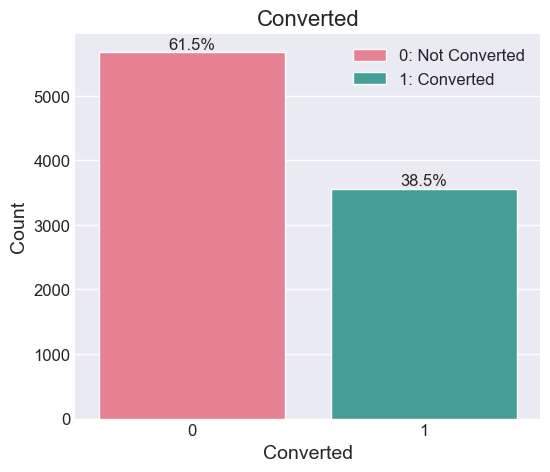

In [50]:
converted_counts = leads_df['Converted'].value_counts()

plt.figure(figsize=(6, 5))
ax = sns.barplot(x=converted_counts.index, y=converted_counts.values, palette='husl')

# Calculate total number of leads to compute percentages
total = sum(converted_counts.values)

# Annotating each bar with the percentage
for p in ax.patches:
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12)

# Adding title and labels
plt.title('Converted', fontsize=16)
plt.xlabel('Converted', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adding a legend for "0" and "1"
labels = ['0: Not Converted', '1: Converted']
plt.legend(handles=ax.patches, labels=labels, loc='upper right', fontsize=12)

plt.show()


- There are more leads that did **not convert** compared to those that **converted** suggesting a possibility to improve the conversions.

In [51]:
#Printing the values of conversions
print(leads_df['Converted'].value_counts(dropna=False))
print(leads_df['Converted'].dtype)


Converted
0    5679
1    3561
Name: count, dtype: int64
int64


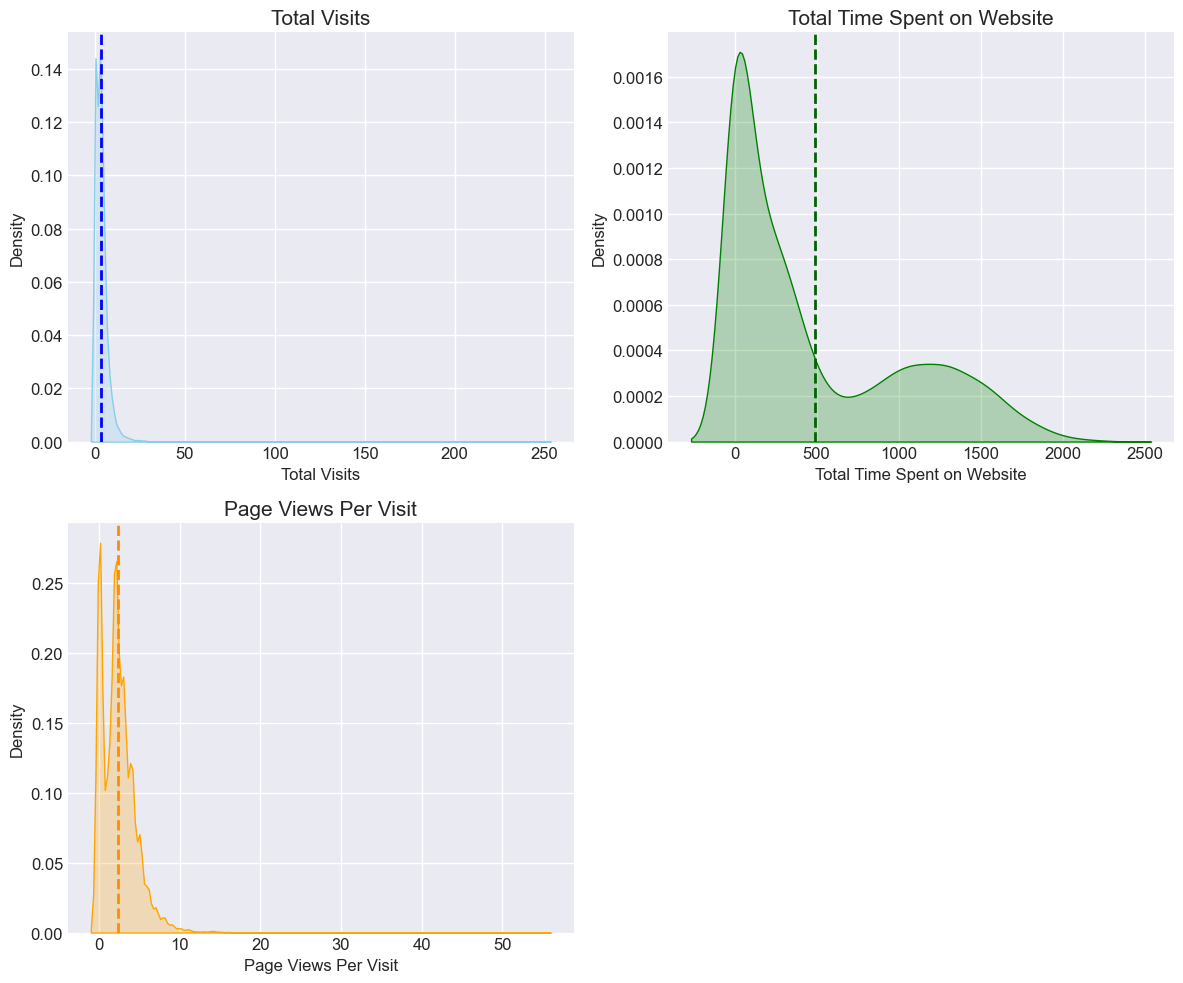

In [52]:
plt.figure(figsize=(12, 10))  # Set figure size

# Subplot 1: KDE for Total Visits
plt.subplot(221)
sns.kdeplot(leads_df['TotalVisits'], shade=True, color='skyblue')
plt.axvline(leads_df['TotalVisits'].mean(), color='blue', linestyle='--', linewidth=2)  # Vertical line for mean
plt.title('Total Visits', fontsize=15)
plt.xlabel('Total Visits', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)

# Subplot 2: KDE for Total Time Spent on Website
plt.subplot(222)
sns.kdeplot(leads_df['Total Time Spent on Website'], shade=True, color='green')
plt.axvline(leads_df['Total Time Spent on Website'].mean(), color='darkgreen', linestyle='--', linewidth=2)
plt.title('Total Time Spent on Website', fontsize=15)
plt.xlabel('Total Time Spent on Website', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)

# Subplot 3: KDE for Page Views Per Visit
plt.subplot(223)
sns.kdeplot(leads_df['Page Views Per Visit'], shade=True, color='orange')
plt.axvline(leads_df['Page Views Per Visit'].mean(), color='darkorange', linestyle='--', linewidth=2)
plt.title('Page Views Per Visit', fontsize=15)
plt.xlabel('Page Views Per Visit', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


**Skewness**: All three plots exhibit right skewness, meaning that most users fall within a lower range, but a few users have much higher values, causing a long tail.

**Behavior Clustering**: In the Total Time Spent on Website, the presence of two peaks suggests that there could be different segments of users—those who spend little time and those who spend a lot more.

**Outliers**: The long tails in each of these distributions may indicate the presence of outliers.

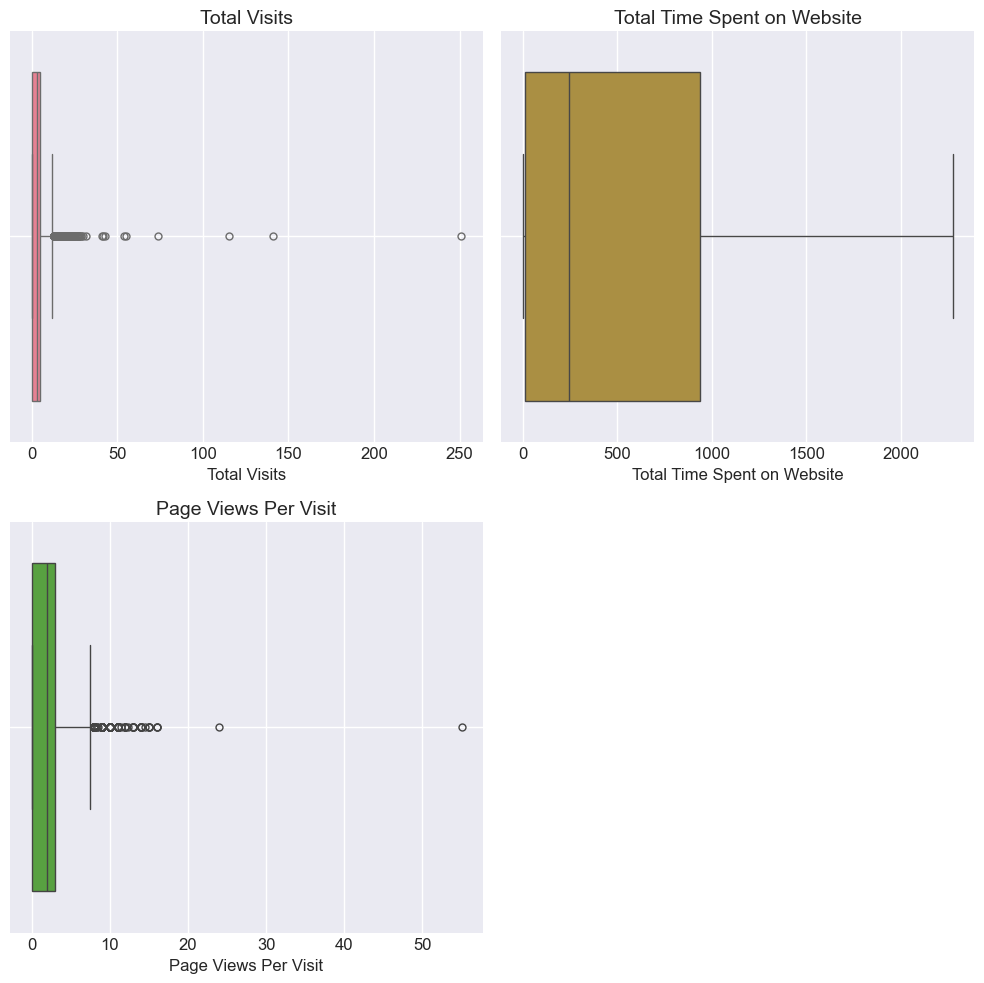

In [53]:
plt.figure(figsize=(10, 10))

# Set consistent palette
palette = sns.color_palette("husl")

# Subplot 1: Box Plot for Total Visits
plt.subplot(221)
sns.boxplot(data=leads_df, x='TotalVisits', color=palette[0], fliersize=5)  # fliersize controls outlier marker size
plt.title('Total Visits', fontsize=14)
plt.xlabel('Total Visits', fontsize=12)
plt.grid(True)

# Subplot 2: Box Plot for Total Time Spent on Website
plt.subplot(222)
sns.boxplot(data=leads_df, x='Total Time Spent on Website', color=palette[1], fliersize=5)
plt.title('Total Time Spent on Website', fontsize=14)
plt.xlabel('Total Time Spent on Website', fontsize=12)
plt.grid(True)

# Subplot 3: Box Plot for Page Views Per Visit
plt.subplot(223)
sns.boxplot(data=leads_df, x='Page Views Per Visit', color=palette[2], fliersize=5)
plt.title('Page Views Per Visit', fontsize=14)
plt.xlabel('Page Views Per Visit', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


1. **Total Visits**: Most users have fewer than 10 visits, but there are significant outliers with very high visit counts, indicating some unusual or highly engaged behavior.
2. **Total Time Spent on Website**: Users generally spend between 250 and 950 seconds on the website, with a few outliers spending up to 2,000 seconds.
3. **Page Views Per Visit**: Most users view fewer than 10 pages per visit, but there are outliers with over 50 page views, showing high activity from a few users.

In [54]:
# Cap TotalVisits at the 95th percentile
q1 = leads_df["TotalVisits"].quantile(0.95)
leads_df["TotalVisits"] = leads_df["TotalVisits"].apply(lambda x: min(x, q1))

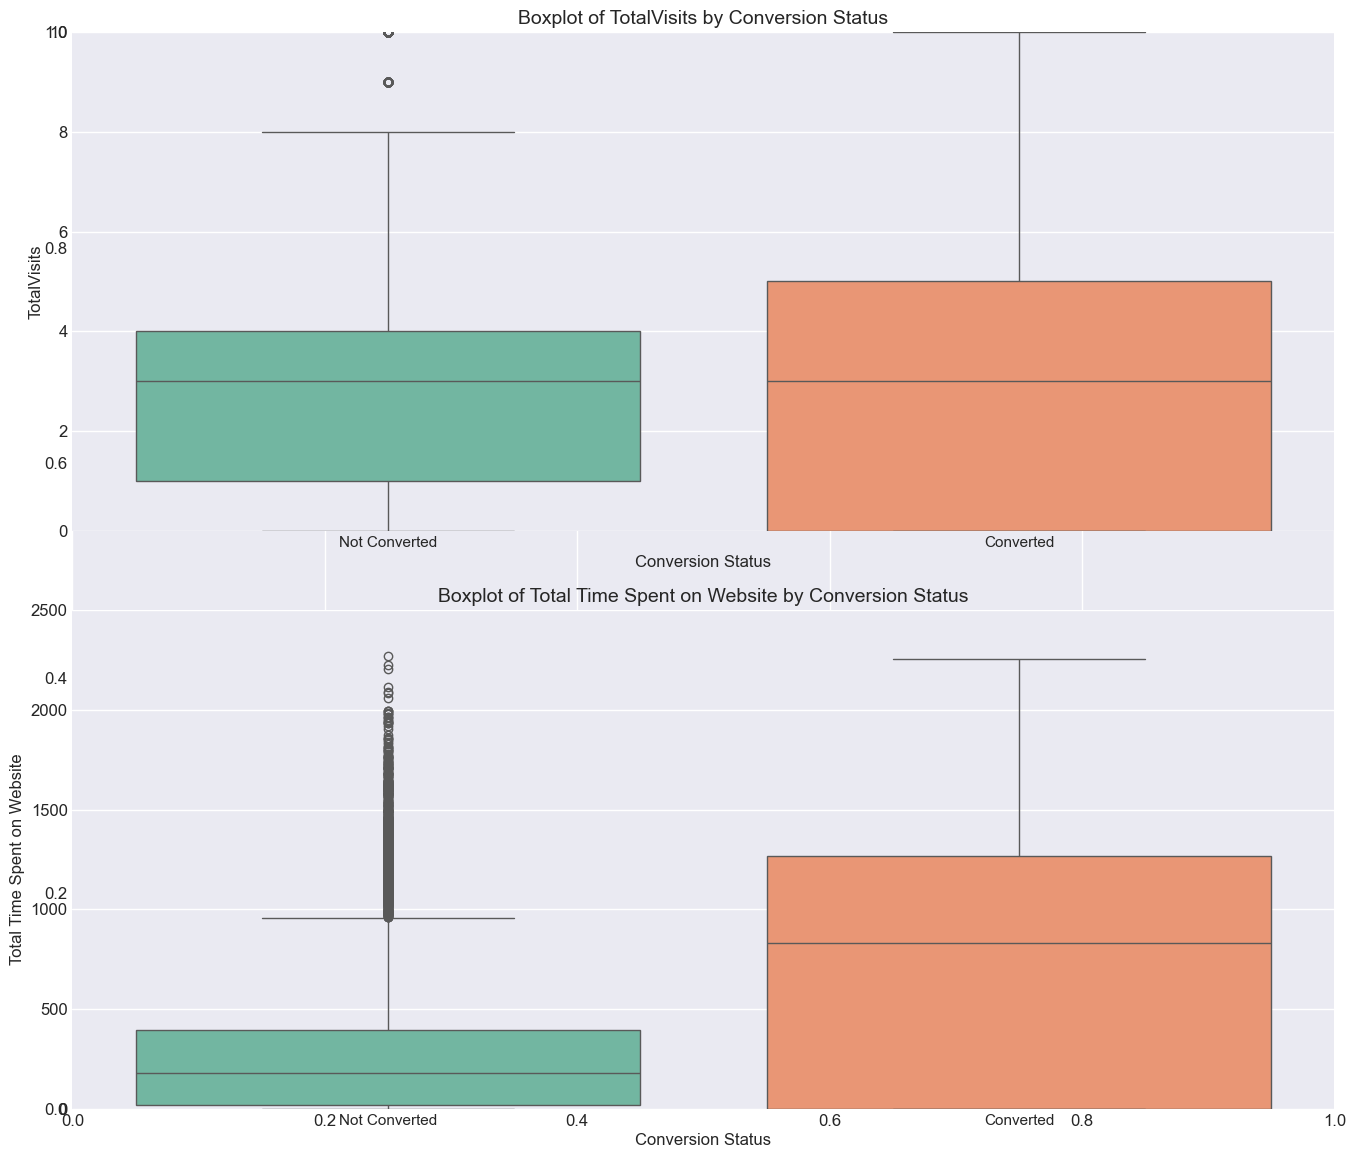

In [55]:
fig, ax = plt.subplots(figsize=(14, 12))

# List of features
features = ["TotalVisits", "Total Time Spent on Website"]

# Loop through features and create subplots
for i, feature in enumerate(features):
    # Create a subplot
    plt.subplot(2, 1, i + 1)
    plt.subplots_adjust(hspace=0.5)  # Add more space between subplots
    
    # Create the boxplot
    sns.boxplot(x='Converted', y=feature, data=leads_df, palette='Set2')
    
    # Add titles and labels
    plt.title(f'Boxplot of {feature} by Conversion Status', fontsize=14)
    plt.xlabel('Conversion Status', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    
    # Adjust x-ticks for clarity
    plt.xticks(ticks=[0, 1], labels=['Not Converted', 'Converted'], fontsize=11)
    
    # Set the y-axis limit for better comparison (optional)
    if feature == 'TotalVisits':
        plt.ylim(0, 10)
    elif feature == 'Total Time Spent on Website':
        plt.ylim(0, 2500)

# Ensure the layout doesn't overlap
plt.tight_layout()
plt.show()


### Multivariate Analysis

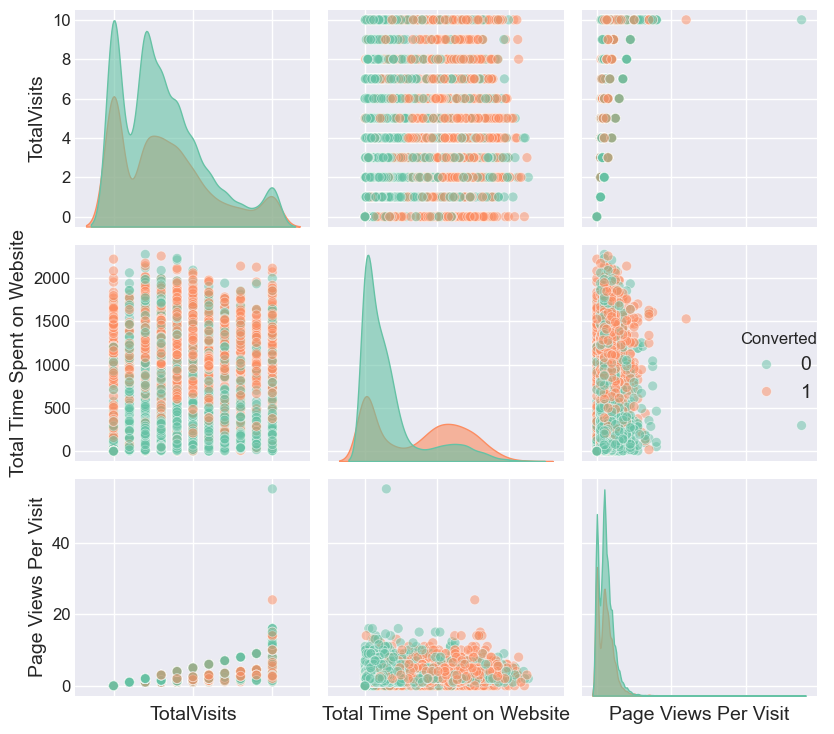

In [56]:
g = sns.pairplot(leads_df[['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Converted']], 
                 hue='Converted', 
                 palette='Set2', 
                 plot_kws={'alpha': 0.5, 's': 50},  # Adjust transparency and size of points
                 diag_kws={'alpha': 0.6})  # Adjust transparency for diagonal KDE plots

# Rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()  # Ensure the layout doesn't overlap
plt.show()


- **Total Visits**: The distribution of total visits shows that both converted and non-converted leads have similar patterns, with most users having fewer than 10 visits. However, converted leads tend to have slightly higher visits in some cases.
- **Total Time Spent on Website**: There is a notable difference between converted and non-converted leads. Converted leads generally spend more time on the website compared to non-converted leads, with a clear separation beyond 500 seconds.
- **Page Views Per Visit**: Distribution shows a small range, with most users viewing fewer than 10 pages per visit. There are a few outliers with significantly more page views, but no major difference is evident between converted and non-converted leads in this feature.

This plot suggests that **Total Time Spent on Website** could be a strong indicator of conversion, while **Total Visits** and **Page Views Per Visit** may offer less predictive value on their own.

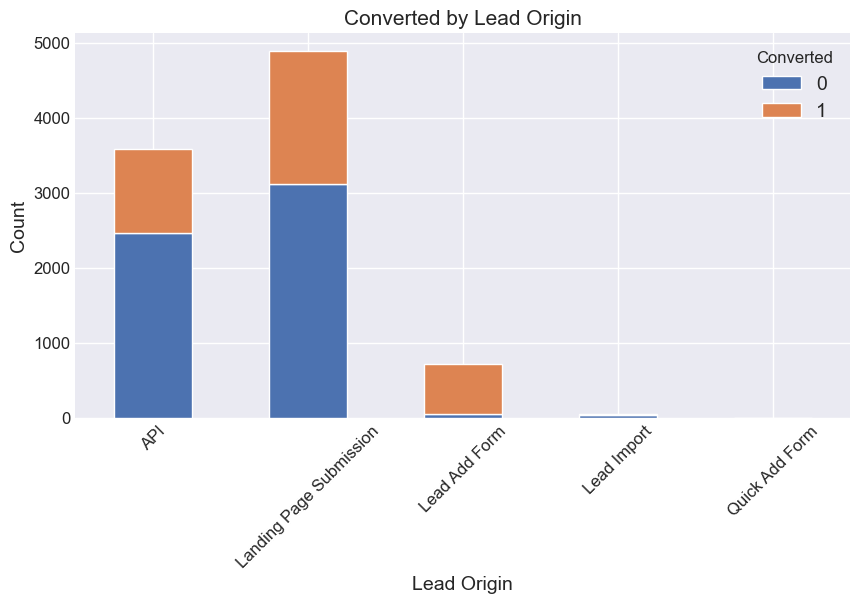

In [57]:
pd.crosstab(leads_df['Lead Origin'], leads_df['Converted']).plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Converted by Lead Origin')
plt.xlabel('Lead Origin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


1. **Landing Page Submission**: This source generates the highest number of leads, with a significant proportion converting, showing it is highly effective.
2. **API**: The second-largest source of leads with a decent number of conversions, though a relatively larger proportion of leads do not convert.
3. **Lead Add Form**: Generates fewer leads overall, but most of them convert, indicating good effectiveness.
4. **Lead Import and Quick Add Form**: These sources contribute very few leads, with almost no conversions, making them less significant. 

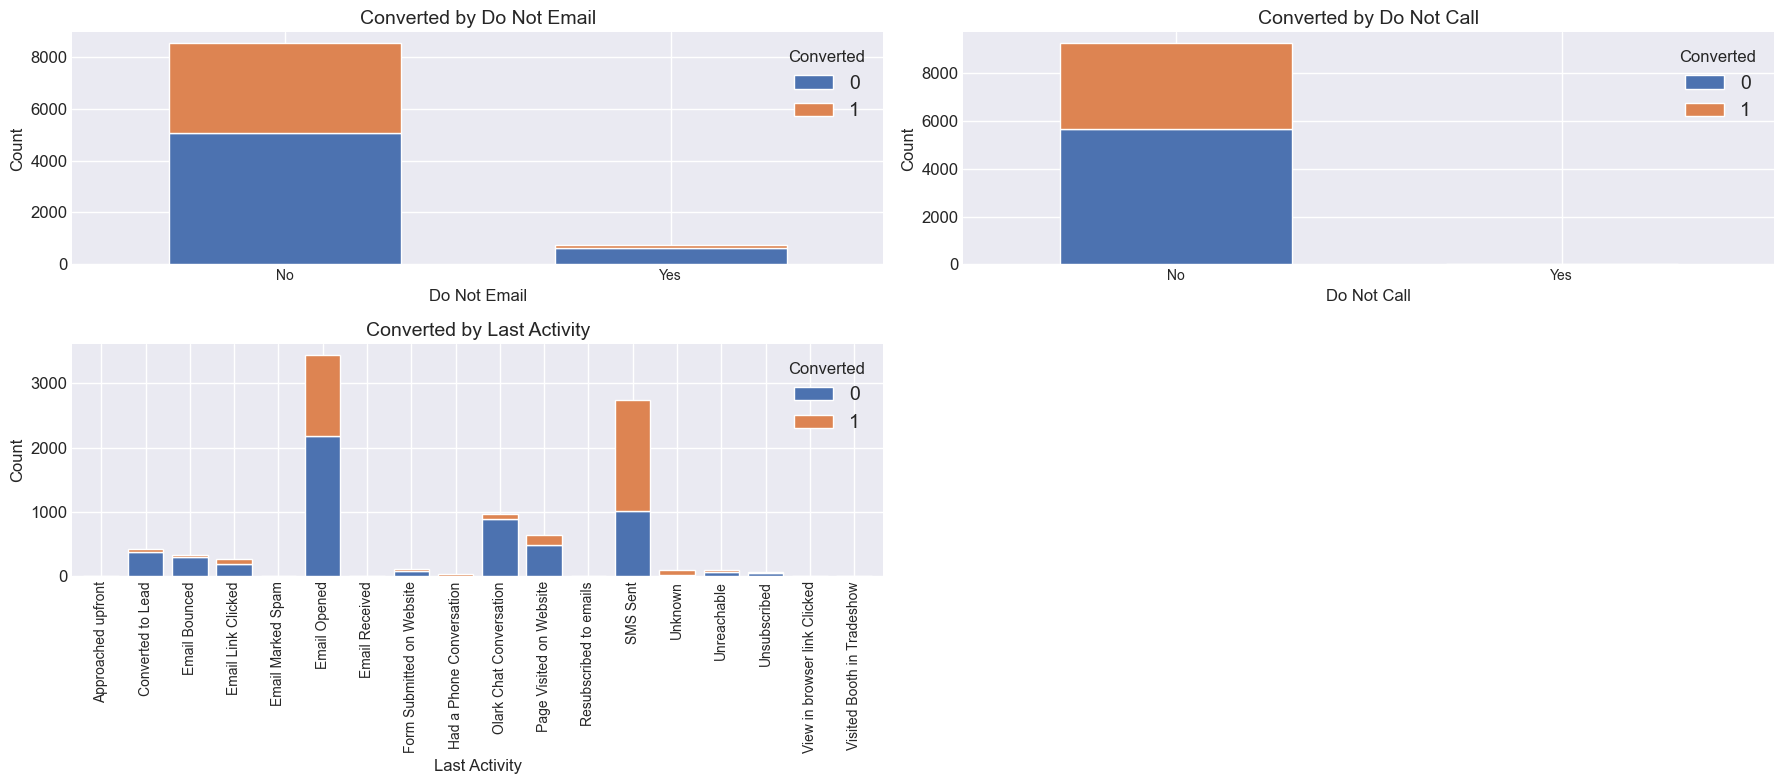

In [58]:
plt.figure(figsize=(20, 10))

# Subplot 1: Stacked Bar Plot for 'Do Not Email'
plt.subplot(2, 2, 1)
pd.crosstab(leads_df['Do Not Email'], leads_df['Converted']).plot(kind='bar', stacked=True, figsize=(9, 8), width=0.6, ax=plt.gca())
plt.title('Converted by Do Not Email', fontsize=14)
plt.xlabel('Do Not Email', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)

# Subplot 2: Stacked Bar Plot for 'Do Not Call'
plt.subplot(2, 2, 2)
pd.crosstab(leads_df['Do Not Call'], leads_df['Converted']).plot(kind='bar', stacked=True, figsize=(9, 8), width=0.6, ax=plt.gca())
plt.title('Converted by Do Not Call', fontsize=14)
plt.xlabel('Do Not Call', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)

# Subplot 3: Stacked Bar Plot for 'Last Activity'
plt.subplot(2, 2, 3)
pd.crosstab(leads_df['Last Activity'], leads_df['Converted']).plot(kind='bar', stacked=True, figsize=(18, 8), width=0.8, ax=plt.gca())
plt.title('Converted by Last Activity', fontsize=14)
plt.xlabel('Last Activity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels to handle long activity names

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


1. **Do Not Email**: Most leads have not opted for "Do Not Email," and these leads show a higher proportion of conversions compared to those who opted out of emails.
   
2. **Do Not Call**: The vast majority of leads have not opted for "Do Not Call," with similar proportions of converted and non-converted leads, suggesting minimal impact of this factor on conversions.

3. **Last Activity**: **Email Opened** and **SMS Sent** are the most frequent last activities before conversion, with **SMS Sent** showing a higher conversion rate relative to other activities.

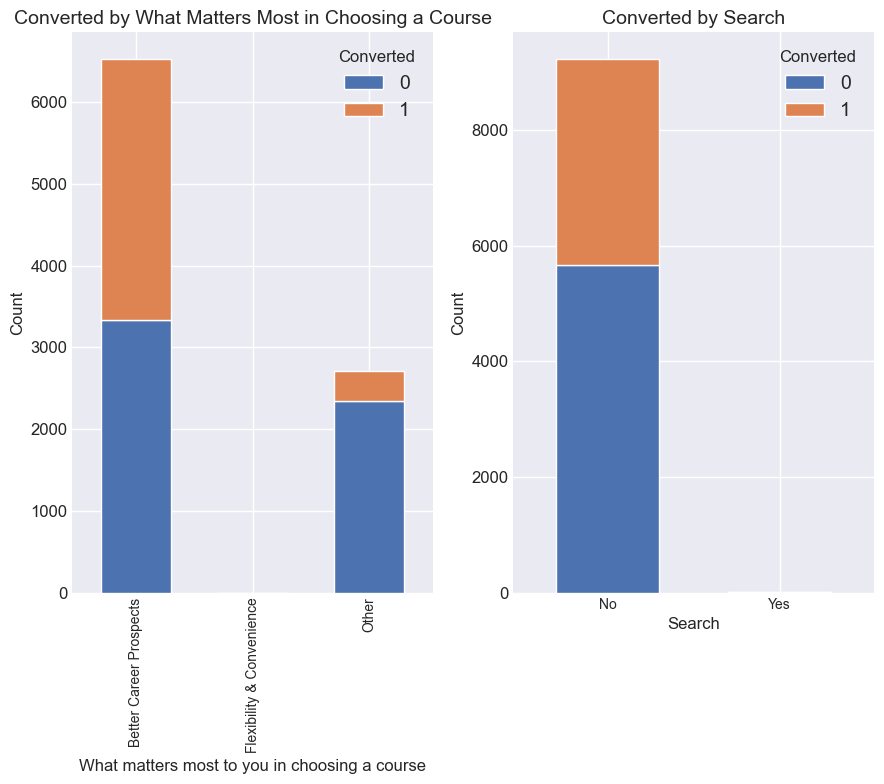

In [59]:
plt.figure(figsize=(8, 8))

# Subplot 1: Stacked Bar Plot for 'What matters most to you in choosing a course'
plt.subplot(1, 2, 1)
pd.crosstab(leads_df['What matters most to you in choosing a course'], leads_df['Converted']).plot(kind='bar', stacked=True, figsize=(9, 8), width=0.6, ax=plt.gca())
plt.title('Converted by What Matters Most in Choosing a Course', fontsize=14)
plt.xlabel('What matters most to you in choosing a course', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# Subplot 2: Stacked Bar Plot for 'Search'
plt.subplot(1, 2, 2)
pd.crosstab(leads_df['Search'], leads_df['Converted']).plot(kind='bar', stacked=True, figsize=(9, 8), width=0.6, ax=plt.gca())
plt.title('Converted by Search', fontsize=14)
plt.xlabel('Search', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


1. **What Matters Most in Choosing a Course**: The majority of leads prioritize **Better Career Prospects**, and a significant portion of these leads convert, indicating that this is a strong driver of conversions.
2. **Search**: Most leads do not use the search feature, and the conversion rate among both those who use it and those who don’t appears to be similar, indicating minimal impact from this factor.

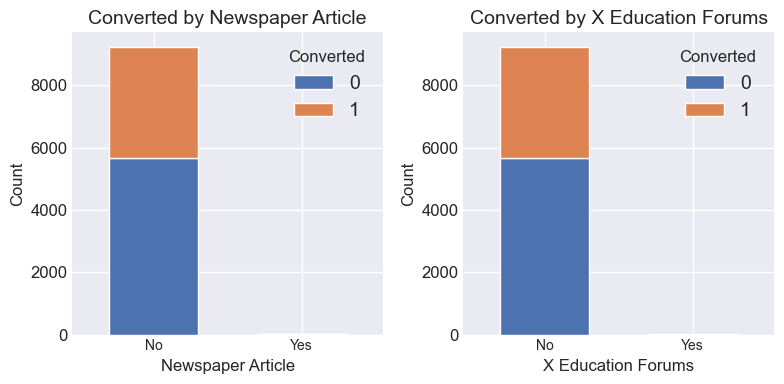

In [60]:
plt.figure(figsize=(5, 8))  

# Subplot 1: Stacked Bar Plot for 'Newspaper Article'
plt.subplot(1, 2, 1)
pd.crosstab(leads_df['Newspaper Article'], leads_df['Converted']).plot(kind='bar', stacked=True, figsize=(8, 4), width=0.6, ax=plt.gca())
plt.title('Converted by Newspaper Article', fontsize=14)
plt.xlabel('Newspaper Article', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)

# Subplot 2: Stacked Bar Plot for 'X Education Forums'
plt.subplot(1, 2, 2)
pd.crosstab(leads_df['X Education Forums'], leads_df['Converted']).plot(kind='bar', stacked=True, figsize=(8, 4), width=0.6, ax=plt.gca())
plt.title('Converted by X Education Forums', fontsize=14)
plt.xlabel('X Education Forums', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


1. **Newspaper Article**: The vast majority of leads did not engage through a newspaper article, and among them, there is a higher proportion of conversions, suggesting minimal impact from newspaper articles.
   
2. **X Education Forums**: Similarly, most leads did not use X Education Forums, and the conversion rate among these leads is higher, indicating that this source also has a minimal role in lead conversion.

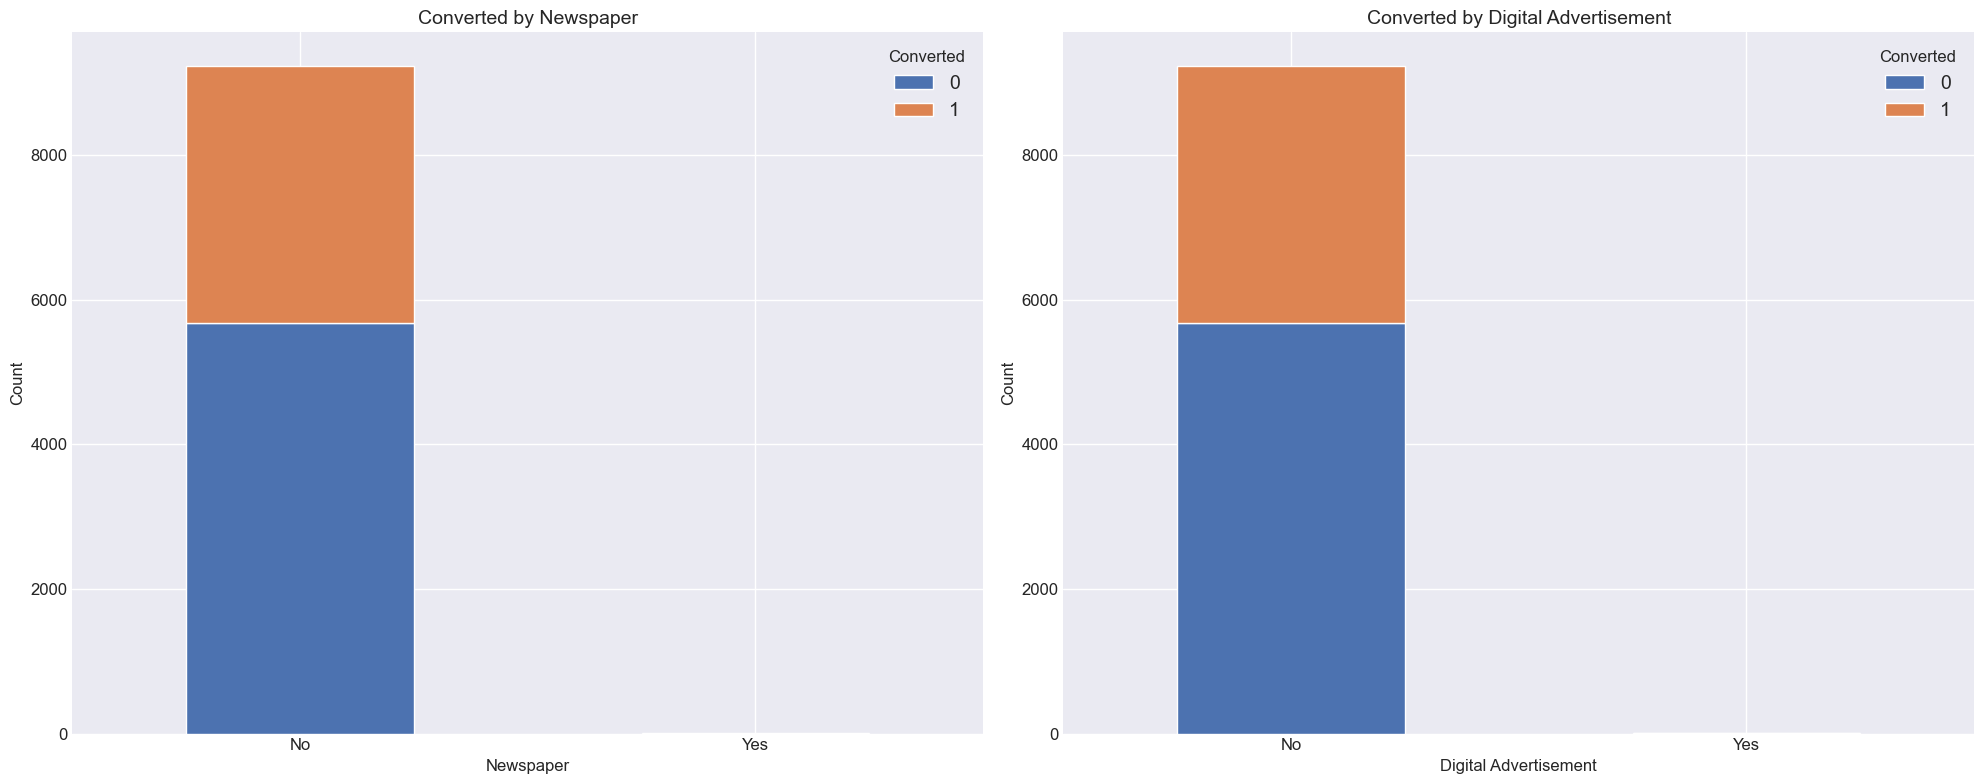

In [61]:
plt.figure(figsize=(20, 8))

# Subplot 1: Stacked Bar Plot for 'Newspaper' (Count Plot)
plt.subplot(1, 2, 1)
newspaper_crosstab = pd.crosstab(leads_df['Newspaper'], leads_df['Converted'])
newspaper_crosstab.plot(kind='bar', stacked=True, ax=plt.gca())  # Plotting counts
plt.title('Converted by Newspaper', fontsize=14)
plt.xlabel('Newspaper', fontsize=12)
plt.ylabel('Count', fontsize=12)  # Change to count
plt.xticks(rotation=0)

# Subplot 2: Stacked Bar Plot for 'Digital Advertisement' (Count Plot)
plt.subplot(1, 2, 2)
digital_ad_crosstab = pd.crosstab(leads_df['Digital Advertisement'], leads_df['Converted'])
digital_ad_crosstab.plot(kind='bar', stacked=True, ax=plt.gca())  # Plotting counts
plt.title('Converted by Digital Advertisement', fontsize=14)
plt.xlabel('Digital Advertisement', fontsize=12)
plt.ylabel('Count', fontsize=12)  # Change to count
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


1. **Newspaper**: Most leads did not come from a newspaper source, and among them, there is a higher proportion of conversions, indicating that the newspaper source is not a significant factor in driving conversions.

2. **Digital Advertisement**: Similar to the newspaper source, most leads did not engage through digital advertisements, and the proportion of conversions from this source is also relatively low, suggesting it has minimal impact on conversions.

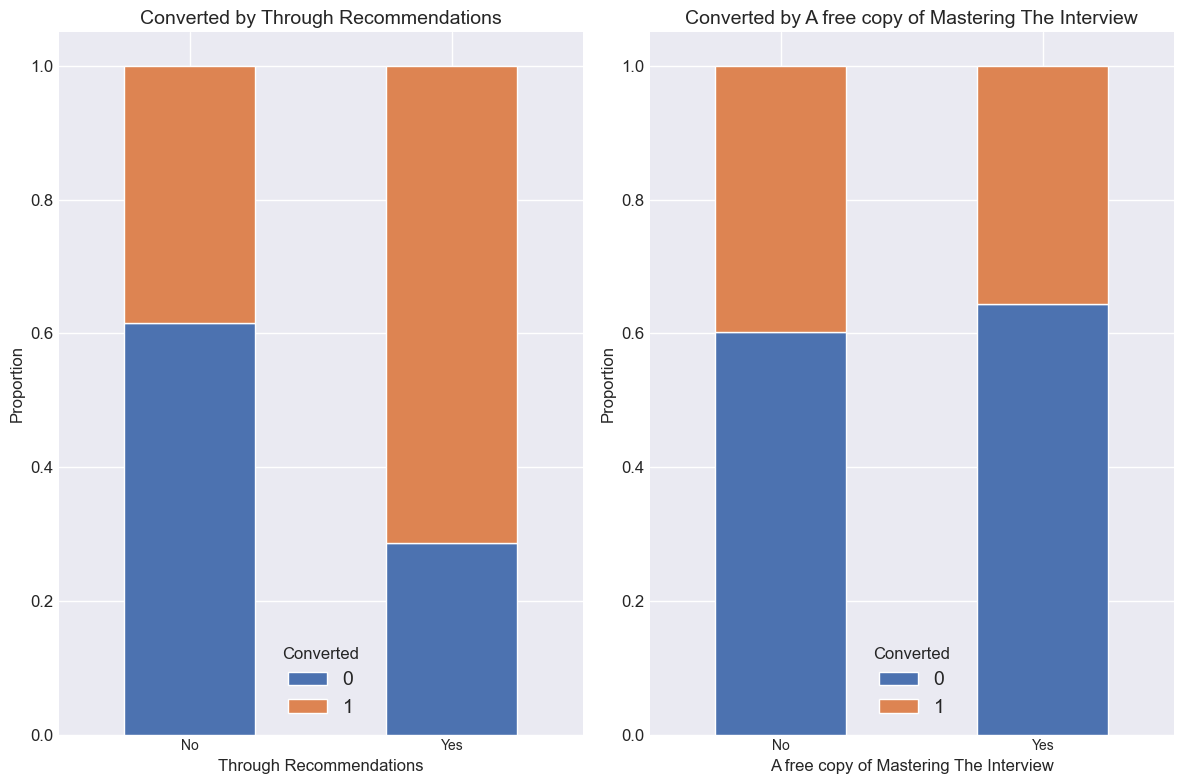

In [62]:
plt.figure(figsize=(12, 8))

# Subplot 1: Stacked Bar Plot for 'Through Recommendations'
plt.subplot(1, 2, 1)
recommendations_crosstab = pd.crosstab(leads_df['Through Recommendations'], leads_df['Converted'])
recommendations_crosstab.div(recommendations_crosstab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Converted by Through Recommendations', fontsize=14)
plt.xlabel('Through Recommendations', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0, fontsize=10)

# Subplot 2: Stacked Bar Plot for 'A free copy of Mastering The Interview'
plt.subplot(1, 2, 2)
interview_copy_crosstab = pd.crosstab(leads_df['A free copy of Mastering The Interview'], leads_df['Converted'])
interview_copy_crosstab.div(interview_copy_crosstab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Converted by A free copy of Mastering The Interview', fontsize=14)
plt.xlabel('A free copy of Mastering The Interview', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


1. **Through Recommendations**: Most leads did not come through recommendations, and among those who did not, the proportion of conversions is lower, suggesting recommendations may have a positive impact on conversions.

2. **A Free Copy of Mastering The Interview**: Leads who received a free copy of this resource have a higher conversion rate compared to those who did not receive it, indicating that this free offer is an effective incentive for conversions.

<Figure size 1200x800 with 0 Axes>

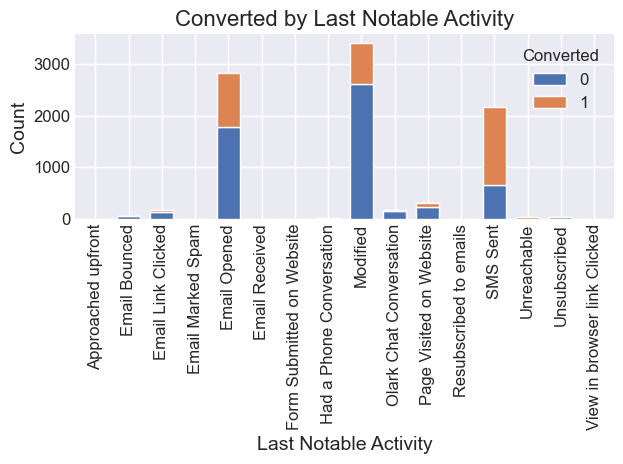

In [63]:
# Crosstab for Last Notable Activity and Converted
last_notable_activity_ct = pd.crosstab(leads_df['Last Notable Activity'], leads_df['Converted'])

# Plotting the stacked bar plot with counts
plt.figure(figsize=(12, 8))
last_notable_activity_ct.plot(kind='bar', stacked=True, width=0.7)

# Customizing the plot
plt.title('Converted by Last Notable Activity', fontsize=16)
plt.xlabel('Last Notable Activity', fontsize=14)
plt.ylabel('Count', fontsize=14)  # Changed to Count
plt.xticks(rotation=90, fontsize=12)  # Rotating the x-axis labels for readability
plt.legend(title='Converted', fontsize=12)

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


The **Last Notable Activity** plot shows that the activities with the highest number of leads and conversions are **"Email Opened"** and **"Modified"**, followed by **"SMS Sent"**. These activities appear to be key interactions that lead to successful conversions. Activities like **"Olark Chat Conversation"** and **"Page Visited on Website"** also have some conversions, but at lower volumes, suggesting their influence is less prominent.

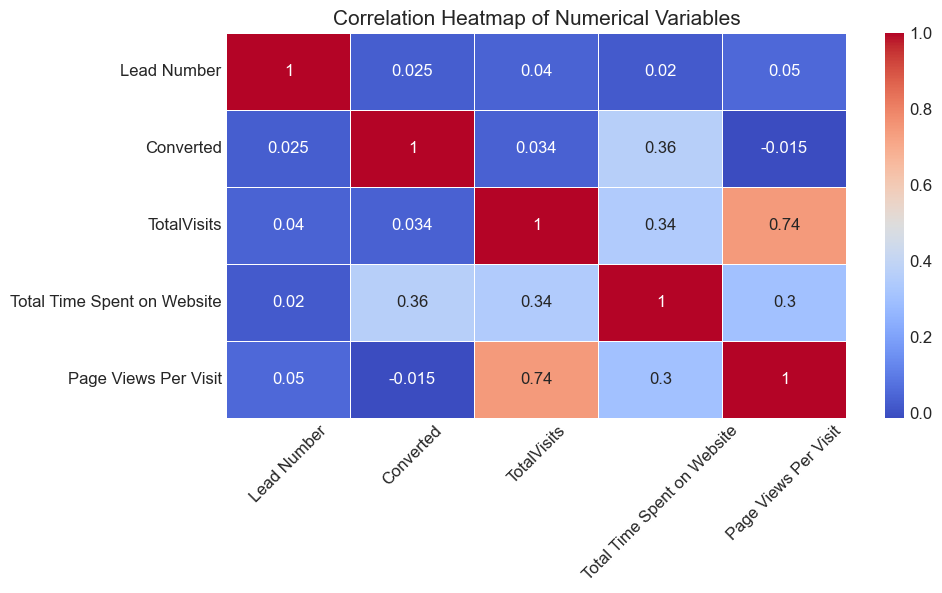

In [64]:
# Select only the numerical columns from the 'leads' DataFrame
numerical_columns = leads_df.select_dtypes(include=['float64', 'int64']).columns

# Create the correlation matrix for numerical variables
correlation_matrix = leads_df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10,5))  # Adjust the figure size as necessary
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()


- **Total Visits** and **Page Views Per Visit** have a high positive correlation (0.74), suggesting potential multicollinearity, as these variables might provide redundant information.
- **Converted** has a moderate positive correlation (0.36) with **Total Time Spent on Website**, indicating that users who spend more time on the website are more likely to convert.
- Other correlations between variables are relatively low, showing weak relationships between them.

#### Data Cleaning & Preparation - Dropping irrelevant and imbalanced features

In [65]:
#Based on the above analysis, the features which we believe do not contribute much information can be dropped after confirming the contribution as:
for col in ['Do Not Call', 'What matters most to you in choosing a course', 'Search', 
            'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 
            'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 
            'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'City', 'Country']:
    print(f"Value counts for {col}:\n", leads_df[col].value_counts(normalize=True) * 100)


Value counts for Do Not Call:
 Do Not Call
No     99.978355
Yes     0.021645
Name: proportion, dtype: float64
Value counts for What matters most to you in choosing a course:
 What matters most to you in choosing a course
Better Career Prospects      70.649351
Other                        29.329004
Flexibility & Convenience     0.021645
Name: proportion, dtype: float64
Value counts for Search:
 Search
No     99.848485
Yes     0.151515
Name: proportion, dtype: float64
Value counts for Magazine:
 Magazine
No    100.0
Name: proportion, dtype: float64
Value counts for Newspaper Article:
 Newspaper Article
No     99.978355
Yes     0.021645
Name: proportion, dtype: float64
Value counts for X Education Forums:
 X Education Forums
No     99.989177
Yes     0.010823
Name: proportion, dtype: float64
Value counts for Newspaper:
 Newspaper
No     99.989177
Yes     0.010823
Name: proportion, dtype: float64
Value counts for Digital Advertisement:
 Digital Advertisement
No     99.95671
Yes     0.04329


#### From the analysis, found that following columns do not provide insightful information and can be dropped for further analysis:

- 'Do Not Call',
- 'What matters most to you in choosing a course',
- 'Search',
- 'Magazine',
- 'Newspaper Article',
- 'X Education Forums',
- 'Newspaper',
- 'Digital Advertisement',
- 'Through Recommendations',
- 'Receive More Updates About Our Courses',
- 'Update me on Supply Chain Content',
- 'Get updates on DM Content',
- 'I agree to pay the amount through cheque'
- 'City'
- 'Country'

In [66]:
# Dropping variables with highly imbalanced data
leads_df.drop(['Do Not Call', 'What matters most to you in choosing a course', 'Search', 'Magazine', 
               'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 
               'Through Recommendations', 'Receive More Updates About Our Courses', 
               'Update me on Supply Chain Content', 'Get updates on DM Content', 
               'I agree to pay the amount through cheque', 'City','Country'], axis=1, inplace=True)

In [67]:
# Dropping the columns which have unique values and will not provide useful information for further analysis
# Therefore, dropping 'Prospect ID' and 'Lead Number' columns

leads_df.drop(['Prospect ID','Lead Number'], axis = 1, inplace = True)

leads_df.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity', 'Specialization', 'What is your current occupation', 'A free copy of Mastering The Interview', 'Last Notable Activity'], dtype='object')

In [68]:
#analysing the leads as
leads_df.head()


Lead Origin     Lead Source Do Not Email  Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit            Last Activity           Specialization What is your current occupation A free copy of Mastering The Interview Last Notable Activity
0                      API      olark chat           No          0          0.0                            0                   0.0  Page Visited on Website                   others                      Unemployed                                     No              Modified
1                      API  organic search           No          0          5.0                          674                   2.5             Email Opened                   others                      Unemployed                                     No          Email Opened
2  Landing Page Submission  direct traffic           No          1          2.0                         1532                   2.0             Email Opened  Business Administration                         Student                                    Yes          Email Opened
3  Landing Page Submission  direct traffic           No          0          1.0                          305                   1.0              Unreachable    Media and Advertising                      Unemployed                                     No              Modified
4  Landing Page Submission          google           No          1          2.0                         1428                   1.0        Converted to Lead                   others                      Unemployed                                     No              Modified

In [69]:
# Get the value counts of all the columns

for c in leads_df:
    print(leads[c].astype('category').value_counts())
    print('_'*50)

Lead Origin
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: count, dtype: int64
__________________________________________________
Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Live Chat               2
Press_Release           2
Social Media            2
Pay per Click Ads       1
NC_EDM                  1
WeLearn                 1
blog                    1
testone                 1
welearnblog_Home        1
youtubechannel          1
Name: count, dtype: int64
__________________________________________________
Do Not Email
No     8506
Yes     734
Name: count, dtype: int64
__________________________________________________
Co

**This shows that the selected columns have variety of information**

#### Feature Engineering: Creating Dummy Variables

In [70]:
# Inspecting the different columns in the dataset
columns = leads.columns

# Separate numerical and categorical columns
numeric_cols = leads_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = leads_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Columns:")
print(numeric_cols)
print("\nCategorical Columns:")
print(categorical_cols)


Numerical Columns:
['Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

Categorical Columns:
['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity', 'Specialization', 'What is your current occupation', 'A free copy of Mastering The Interview', 'Last Notable Activity']


In [71]:
# Create dummy variables
dummy = pd.get_dummies(leads_df[categorical_cols], drop_first=True).astype(int)

# Add the dummies to the original dataframe
leads_dum = pd.concat([leads_df, dummy], axis=1)

# Drop only the original categorical columns for which dummies were created
leads_dummy = leads_dum.drop(categorical_cols, axis=1)

# Display the updated DataFrame after dropping
leads_dummy.head()


Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  Lead Origin_Lead Import  Lead Origin_Quick Add Form  Lead Source_blog  Lead Source_click2call  Lead Source_direct traffic  Lead Source_facebook  Lead Source_google  Lead Source_live chat  Lead Source_nc_edm  Lead Source_olark chat  Lead Source_organic search  Lead Source_pay per click ads  Lead Source_press_release  Lead Source_reference  Lead Source_referral sites  Lead Source_social media  Lead Source_testone  Lead Source_unknown  Lead Source_welearn  Lead Source_welearnblog_home  Lead Source_welingak website  Lead Source_youtubechannel  Do Not Email_Yes  Last Activity_Converted to Lead  Last Activity_Email Bounced  Last Activity_Email Link Clicked  Last Activity_Email Marked Spam  Last Activity_Email Opened  Last Activity_Email Received  Last Activity_Form Submitted on Website  Last Activity_Had a Phone Conversation  Last Activity_Olark Chat Conversation  Last Activity_Page Visited on Website  Last Activity_Resubscribed to emails  Last Activity_SMS Sent  Last Activity_Unknown  Last Activity_Unreachable  Last Activity_Unsubscribed  Last Activity_View in browser link Clicked  Last Activity_Visited Booth in Tradeshow  Specialization_Business Administration  Specialization_E-Business  Specialization_E-COMMERCE  Specialization_Finance Management  Specialization_Healthcare Management  Specialization_Hospitality Management  Specialization_Human Resource Management  Specialization_IT Projects Management  Specialization_International Business  Specialization_Marketing Management  Specialization_Media and Advertising  Specialization_Operations Management  Specialization_Retail Management  Specialization_Rural and Agribusiness  Specialization_Services Excellence  Specialization_Supply Chain Management  Specialization_Travel and Tourism  Specialization_others  What is your current occupation_Housewife  What is your current occupation_Other  What is your current occupation_Student  What is your current occupation_Unemployed  What is your current occupation_Working Professional  A free copy of Mastering The Interview_Yes  Last Notable Activity_Email Bounced  Last Notable Activity_Email Link Clicked  Last Notable Activity_Email Marked Spam  Last Notable Activity_Email Opened  Last Notable Activity_Email Received  Last Notable Activity_Form Submitted on Website  Last Notable Activity_Had a Phone Conversation  Last Notable Activity_Modified  Last Notable Activity_Olark Chat Conversation  Last Notable Activity_Page Visited on Website  Last Notable Activity_Resubscribed to emails  Last Notable Activity_SMS Sent  Last Notable Activity_Unreachable  Last Notable Activity_Unsubscribed  Last Notable Activity_View in browser link Clicked
0          0          0.0                            0                   0.0                                    0                          0                        0                           0                 0                       0                           0                     0                   0                      0                   0                       1                           0                              0                          0                      0                           0                         0                    0                    0                    0                             0                             0                           0                 0                                0                            0                                 0                                0                           0                             0                                        0                                       0                                      0                                      1                                     0                       0                      0                          0                           0       

#### Data Preparation for Modeling


In [72]:
# feature set X by dropping the 'Converted' column
X = leads_dummy.drop(['Converted'], axis=1)

# Target variable y (which is 'Converted')
y = leads_dummy['Converted']

# Display the first few rows of X to verify
X.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  Lead Origin_Lead Import  Lead Origin_Quick Add Form  Lead Source_blog  Lead Source_click2call  Lead Source_direct traffic  Lead Source_facebook  Lead Source_google  Lead Source_live chat  Lead Source_nc_edm  Lead Source_olark chat  Lead Source_organic search  Lead Source_pay per click ads  Lead Source_press_release  Lead Source_reference  Lead Source_referral sites  Lead Source_social media  Lead Source_testone  Lead Source_unknown  Lead Source_welearn  Lead Source_welearnblog_home  Lead Source_welingak website  Lead Source_youtubechannel  Do Not Email_Yes  Last Activity_Converted to Lead  Last Activity_Email Bounced  Last Activity_Email Link Clicked  Last Activity_Email Marked Spam  Last Activity_Email Opened  Last Activity_Email Received  Last Activity_Form Submitted on Website  Last Activity_Had a Phone Conversation  Last Activity_Olark Chat Conversation  Last Activity_Page Visited on Website  Last Activity_Resubscribed to emails  Last Activity_SMS Sent  Last Activity_Unknown  Last Activity_Unreachable  Last Activity_Unsubscribed  Last Activity_View in browser link Clicked  Last Activity_Visited Booth in Tradeshow  Specialization_Business Administration  Specialization_E-Business  Specialization_E-COMMERCE  Specialization_Finance Management  Specialization_Healthcare Management  Specialization_Hospitality Management  Specialization_Human Resource Management  Specialization_IT Projects Management  Specialization_International Business  Specialization_Marketing Management  Specialization_Media and Advertising  Specialization_Operations Management  Specialization_Retail Management  Specialization_Rural and Agribusiness  Specialization_Services Excellence  Specialization_Supply Chain Management  Specialization_Travel and Tourism  Specialization_others  What is your current occupation_Housewife  What is your current occupation_Other  What is your current occupation_Student  What is your current occupation_Unemployed  What is your current occupation_Working Professional  A free copy of Mastering The Interview_Yes  Last Notable Activity_Email Bounced  Last Notable Activity_Email Link Clicked  Last Notable Activity_Email Marked Spam  Last Notable Activity_Email Opened  Last Notable Activity_Email Received  Last Notable Activity_Form Submitted on Website  Last Notable Activity_Had a Phone Conversation  Last Notable Activity_Modified  Last Notable Activity_Olark Chat Conversation  Last Notable Activity_Page Visited on Website  Last Notable Activity_Resubscribed to emails  Last Notable Activity_SMS Sent  Last Notable Activity_Unreachable  Last Notable Activity_Unsubscribed  Last Notable Activity_View in browser link Clicked
0          0.0                            0                   0.0                                    0                          0                        0                           0                 0                       0                           0                     0                   0                      0                   0                       1                           0                              0                          0                      0                           0                         0                    0                    0                    0                             0                             0                           0                 0                                0                            0                                 0                                0                           0                             0                                        0                                       0                                      0                                      1                                     0                       0                      0                          0                           0                             

#### Data Splitting for Model Training

In [73]:
# Split the dataset into 70% and 30% for train and test respectively. Random state is 42
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)

#### Numerical Feature Identification


In [74]:
# Removing 'Converted' as it's the target variable
numeric_cols.remove('Converted')

# Displaying the identified numerical columns
print('Numerical columns:', end = '')
print(numeric_cols)
print('_'*50)

Numerical columns:['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
__________________________________________________


Based on the above, the TotalVisits, Total Time Spent on Website and Page Views Per Visit are numerical features and need scaling


#### Feature Scaling


In [75]:
# Scale the three numeric features
scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  Lead Origin_Lead Import  Lead Origin_Quick Add Form  Lead Source_blog  Lead Source_click2call  Lead Source_direct traffic  Lead Source_facebook  Lead Source_google  Lead Source_live chat  Lead Source_nc_edm  Lead Source_olark chat  Lead Source_organic search  Lead Source_pay per click ads  Lead Source_press_release  Lead Source_reference  Lead Source_referral sites  Lead Source_social media  Lead Source_testone  Lead Source_unknown  Lead Source_welearn  Lead Source_welearnblog_home  Lead Source_welingak website  Lead Source_youtubechannel  Do Not Email_Yes  Last Activity_Converted to Lead  Last Activity_Email Bounced  Last Activity_Email Link Clicked  Last Activity_Email Marked Spam  Last Activity_Email Opened  Last Activity_Email Received  Last Activity_Form Submitted on Website  Last Activity_Had a Phone Conversation  Last Activity_Olark Chat Conversation  Last Activity_Page Visited on Website  Last Activity_Resubscribed to emails  Last Activity_SMS Sent  Last Activity_Unknown  Last Activity_Unreachable  Last Activity_Unsubscribed  Last Activity_View in browser link Clicked  Last Activity_Visited Booth in Tradeshow  Specialization_Business Administration  Specialization_E-Business  Specialization_E-COMMERCE  Specialization_Finance Management  Specialization_Healthcare Management  Specialization_Hospitality Management  Specialization_Human Resource Management  Specialization_IT Projects Management  Specialization_International Business  Specialization_Marketing Management  Specialization_Media and Advertising  Specialization_Operations Management  Specialization_Retail Management  Specialization_Rural and Agribusiness  Specialization_Services Excellence  Specialization_Supply Chain Management  Specialization_Travel and Tourism  Specialization_others  What is your current occupation_Housewife  What is your current occupation_Other  What is your current occupation_Student  What is your current occupation_Unemployed  What is your current occupation_Working Professional  A free copy of Mastering The Interview_Yes  Last Notable Activity_Email Bounced  Last Notable Activity_Email Link Clicked  Last Notable Activity_Email Marked Spam  Last Notable Activity_Email Opened  Last Notable Activity_Email Received  Last Notable Activity_Form Submitted on Website  Last Notable Activity_Had a Phone Conversation  Last Notable Activity_Modified  Last Notable Activity_Olark Chat Conversation  Last Notable Activity_Page Visited on Website  Last Notable Activity_Resubscribed to emails  Last Notable Activity_SMS Sent  Last Notable Activity_Unreachable  Last Notable Activity_Unsubscribed  Last Notable Activity_View in browser link Clicked
4715          0.0                     0.000000              0.000000                                    0                          0                        0                           0                 0                       0                           0                     0                   0                      0                   0                       1                           0                              0                          0                      0                           0                         0                    0                    0                    0                             0                             0                           0                 0                                0                            0                                 0                                0                           1                             0                                        0                                       0                                      0                                      0                                     0                       0                      0                          0                           0                          

In [76]:
# Exclude columns with only one unique value
X_train_filtered = X_train.loc[:, X_train.nunique() > 1]

# Calculate the correlation matrix for the filtered dataset
correlation_matrix = X_train_filtered.corr()

# Use Pandas' styling options to display the table with updated methods
correlation_matrix.style.set_properties(**{'text-align': 'center'}).background_gradient(cmap='coolwarm').format(precision=2).set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '8px')]}]
)


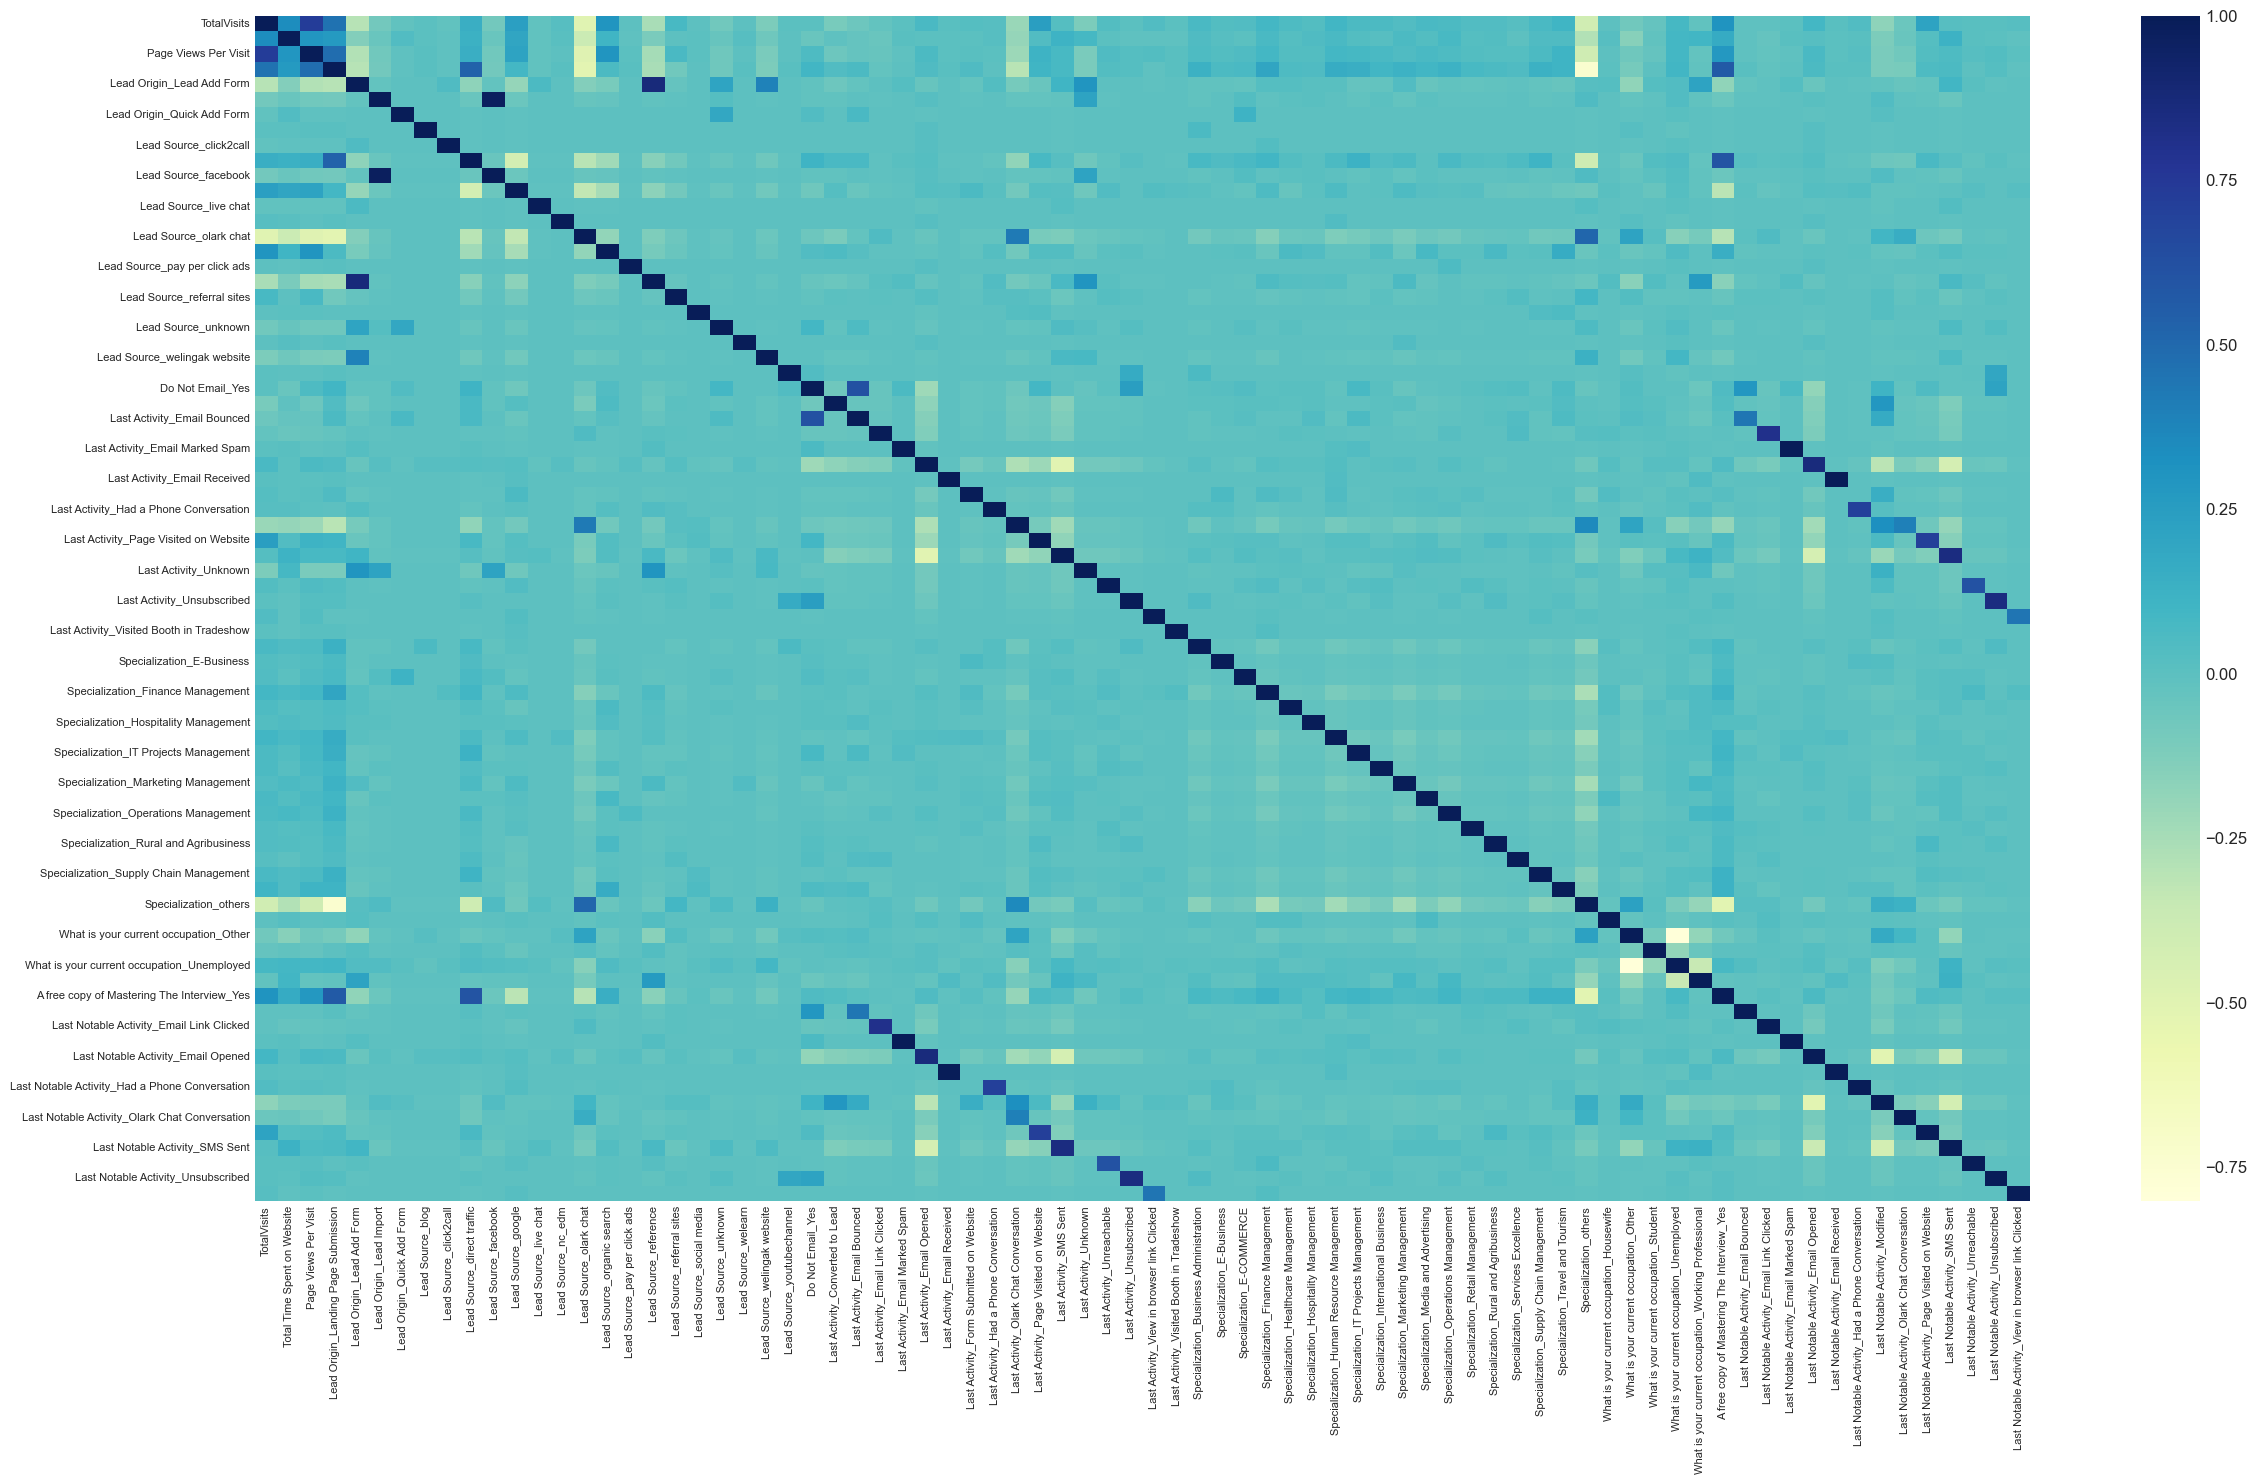

In [77]:
# Looking at the correlation

plt.figure(figsize = (25,15))
sns.heatmap(correlation_matrix, cmap="YlGnBu")  # , annot = True, annot_kws={"size": 6}
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

#### Model Building - Logistic Regression

In [78]:
# import 'LogisticRegression' and create a LogisticRegression object

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [79]:
# too many columns so need to reduce to most relevant factors

# importing RFE and selecting 15 variables

from sklearn.feature_selection import RFE
rfe = RFE(logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', np.False_, np.int64(12)),
 ('Total Time Spent on Website', np.True_, np.int64(1)),
 ('Page Views Per Visit', np.True_, np.int64(1)),
 ('Lead Origin_Landing Page Submission', np.False_, np.int64(3)),
 ('Lead Origin_Lead Add Form', np.True_, np.int64(1)),
 ('Lead Origin_Lead Import', np.False_, np.int64(57)),
 ('Lead Origin_Quick Add Form', np.False_, np.int64(51)),
 ('Lead Source_blog', np.False_, np.int64(41)),
 ('Lead Source_click2call', np.False_, np.int64(46)),
 ('Lead Source_direct traffic', np.False_, np.int64(7)),
 ('Lead Source_facebook', np.False_, np.int64(11)),
 ('Lead Source_google', np.False_, np.int64(10)),
 ('Lead Source_live chat', np.False_, np.int64(45)),
 ('Lead Source_nc_edm', np.False_, np.int64(19)),
 ('Lead Source_olark chat', np.False_, np.int64(18)),
 ('Lead Source_organic search', np.False_, np.int64(9)),
 ('Lead Source_pay per click ads', np.False_, np.int64(39)),
 ('Lead Source_press_release', np.False_, np.int64(68)),
 ('Lead Source_referenc

In [80]:

print("Print Columns selected by RFE. We will manually eliminate for these columns")
print(X_train.columns[rfe.support_])
print()
print("Features not selected by RFE")
print(X_train.columns[~rfe.support_])

Print Columns selected by RFE. We will manually eliminate for these columns
Index(['Total Time Spent on Website', 'Page Views Per Visit', 'Lead Origin_Lead Add Form', 'Lead Source_welingak website', 'Do Not Email_Yes', 'Last Activity_Email Opened', 'Last Activity_SMS Sent', 'What is your current occupation_Housewife', 'What is your current occupation_Other', 'What is your current occupation_Working Professional', 'Last Notable Activity_Email Opened', 'Last Notable Activity_Had a Phone Conversation', 'Last Notable Activity_Modified', 'Last Notable Activity_Unreachable', 'Last Notable Activity_Unsubscribed'], dtype='object')

Features not selected by RFE
Index(['TotalVisits', 'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import', 'Lead Origin_Quick Add Form', 'Lead Source_blog', 'Lead Source_click2call', 'Lead Source_direct traffic', 'Lead Source_facebook', 'Lead Source_google', 'Lead Source_live chat', 'Lead Source_nc_edm', 'Lead Source_olark chat', 'Lead Source_organic searc

In [81]:
# Select only the columns selected by RFE

colx = X_train.columns[rfe.support_]

X_train = X_train[colx]

In [82]:
X_train.head()


Total Time Spent on Website  Page Views Per Visit  Lead Origin_Lead Add Form  Lead Source_welingak website  Do Not Email_Yes  Last Activity_Email Opened  Last Activity_SMS Sent  What is your current occupation_Housewife  What is your current occupation_Other  What is your current occupation_Working Professional  Last Notable Activity_Email Opened  Last Notable Activity_Had a Phone Conversation  Last Notable Activity_Modified  Last Notable Activity_Unreachable  Last Notable Activity_Unsubscribed
4715                     0.000000              0.000000                          0                             0                 0                           1                       0                                          0                                      1                                                     0                                   1                                               0                               0                                  0                                   0
7132                     0.549296              0.018182                          0                             0                 0                           1                       0                                          0                                      0                                                     0                                   1                                               0                               0                                  0                                   0
8954                     0.170335              0.024182                          0                             0                 0                           0                       1                                          0                                      0                                                     0                                   0                                               0                               0                                  0                                   0
5283                     0.532130              0.224182                          0                             0                 1                           0                       0                                          0                                      0                                                     0                                   0                                               0                               0                                  0                                   0
3003                     0.595951              0.054545                          0                             0                 0                           0                       1                                          0                                      1                                                     0                                   0                                               0                               1                                  0                                   0

#### Model I

In [83]:
# # Now, when we call build_model, capture both the model and X_train_sm

cols = X_train.columns

build_model(cols)
get_vif(cols)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2687.2
Date:                Tue, 22 Oct 2024   Deviance:                       5374.4
Time:                        18:29:03   Pearson chi2:                 6.30e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.3941
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Dropping What is your current occupation_Housewife as it has high P value

#### Model II

In [84]:
cols = cols.drop('What is your current occupation_Housewife')

build_model(cols)
get_vif(cols)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6453
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2691.4
Date:                Tue, 22 Oct 2024   Deviance:                       5382.9
Time:                        18:29:03   Pearson chi2:                 6.31e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.3933
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Dropping Lead Source_welingak website as it has high P value

#### Model III

In [85]:
cols = cols.drop('Lead Source_welingak website')

build_model(cols)
get_vif(cols)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2699.7
Date:                Tue, 22 Oct 2024   Deviance:                       5399.3
Time:                        18:29:03   Pearson chi2:                 6.49e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3918
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Dropping Last Notable Activity_Email Opened as it has high VIF

#### Model IV

In [86]:
cols = cols.drop('Last Notable Activity_Email Opened')

build_model(cols)
get_vif(cols)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6455
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2712.7
Date:                Tue, 22 Oct 2024   Deviance:                       5425.3
Time:                        18:29:03   Pearson chi2:                 6.49e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3893
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

All p-values show the columns are significant and VIF < 4 shows negligible multicollinearity

In [87]:
# Getting the predicted values on the train set
X_train_sm = sm.add_constant(X_train[cols])
res = build_model(cols)
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6455
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2712.7
Date:                Tue, 22 Oct 2024   Deviance:                       5425.3
Time:                        18:29:03   Pearson chi2:                 6.49e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3893
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

4715    0.089747
7132    0.712647
8954    0.637440
5283    0.082148
3003    0.575321
478     0.032517
1352    0.717739
3166    0.919680
7700    0.255977
2647    0.096145
dtype: float64

In [88]:
X_train = X_train[cols]
X_train.columns

Index(['Total Time Spent on Website', 'Page Views Per Visit', 'Lead Origin_Lead Add Form', 'Do Not Email_Yes', 'Last Activity_Email Opened', 'Last Activity_SMS Sent', 'What is your current occupation_Other', 'What is your current occupation_Working Professional', 'Last Notable Activity_Had a Phone Conversation', 'Last Notable Activity_Modified', 'Last Notable Activity_Unreachable', 'Last Notable Activity_Unsubscribed'], dtype='object')

In [89]:
# Reshaping to an array
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.08974708, 0.71264682, 0.63743983, 0.08214819, 0.5753214 ,
       0.03251725, 0.71773891, 0.91967954, 0.2559773 , 0.09614511])

#### Creating a Dataframe

In [90]:
# Data frame with given convertion rate and probablity of predicted ones
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final.head()

Converted  Conversion_Prob
0          0         0.089747
1          1         0.712647
2          0         0.637440
3          0         0.082148
4          0         0.575321

**To find the optimal cutoff Threshold value of Probability. Let's start with default 0.5 value.**

#### Predicting Classes

In [91]:
# Substituting 0 or 1 with the cut off as 0.5
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Converted  Conversion_Prob  Predicted
0          0         0.089747          0
1          1         0.712647          1
2          0         0.637440          1
3          0         0.082148          0
4          0         0.575321          1

#### Model Evaluation

#### Confusion Matrix

In [92]:
show_confusion_mets(y_train_pred_final, 'Converted', 'Predicted')

Accuracy : 80.72
Confusion Matrix :
--------------------
[[3474  510]
 [ 737 1747]]
--------------------
Sensitivity : 70.33
Specificity : 87.2
False Positive Rate : 12.8
Positive predictive power : 77.4
Negative predictive power : 82.5
Precision : 77.4
Recall : 70.33
F1 score: 73.7


- **Accuracy of model is ~81%**

### Evaluation Metrics Summary

- **Sensitivity (Recall)**: 0.7033 (70.33%)
  - Indicates that the model correctly identifies 70.33% of actual positive cases (converted leads).

- **Specificity**: 0.872 (87.2%)
  - Indicates that the model correctly identifies 87.24% of actual negative cases (non-converted leads).

**Next step is to improve the model performance by optmizing threshold values. For that, first we need to plot ROC curve**

#### ROC Curve- Optimize Cut Off

In [93]:
# ROC function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')  # or [1 - True Negative Rate]
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

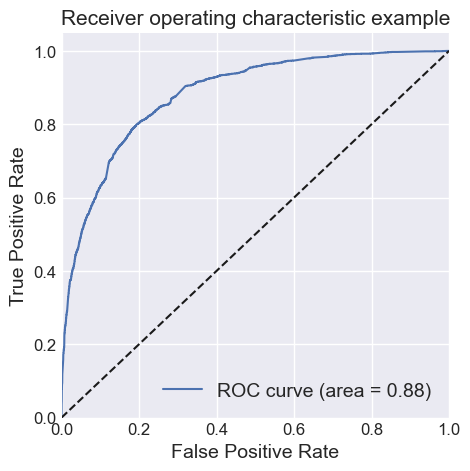

In [94]:
# Calling ROC function
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

- **The ROC curve demonstrates that our model has a strong discriminative ability with an AUC score of 0.88, indicating effective identification of converted leads while maintaining a low false positive rate.**

#### Creating Binary Predictions for Various Probability Cutoffs








In [95]:
# Creating columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Conversion_Prob  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0          0         0.089747          0    1    0    0    0    0    0    0    0    0    0
1          1         0.712647          1    1    1    1    1    1    1    1    1    0    0
2          0         0.637440          1    1    1    1    1    1    1    1    0    0    0
3          0         0.082148          0    1    0    0    0    0    0    0    0    0    0
4          0         0.575321          1    1    1    1    1    1    1    0    0    0    0

#### Evaluation Metrics at Various Probability Cutoffs

In [96]:
# Creating a dataframe to see the values of accuracy, sensitivity, and specificity at different values of probabiity cutoffs
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# Making confusing matrix to find values of sensitivity, accurace and specificity for each level of probablity
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
cutoff_df

prob  accuracy     sensi     speci
0.0   0.0  0.384045  1.000000  0.000000
0.1   0.1  0.627551  0.973027  0.412149
0.2   0.2  0.737322  0.923913  0.620984
0.3   0.3  0.789579  0.830918  0.763805
0.4   0.4  0.805195  0.780193  0.820783
0.5   0.5  0.807205  0.703301  0.871988
0.6   0.6  0.790971  0.586151  0.918675
0.7   0.7  0.779375  0.511272  0.946536
0.8   0.8  0.754947  0.411433  0.969127
0.9   0.9  0.706246  0.250403  0.990462

<Figure size 1000x600 with 0 Axes>

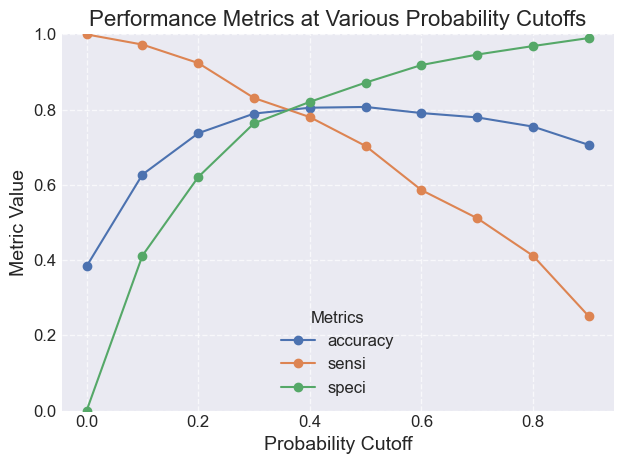

In [97]:
# Plotting accuracy, sensitivity, and specificity
plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
cutoff_df.plot.line(x='prob', y=['accuracy', 'sensi', 'speci'], marker='o')

# Adding titles and labels
plt.title('Performance Metrics at Various Probability Cutoffs', fontsize=16)
plt.xlabel('Probability Cutoff', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.ylim(0, 1)  # Set y-axis limits to [0, 1] for clarity

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding a legend with better positioning
plt.legend(title='Metrics', fontsize=12, loc='best')

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()


- **The cut off value appears between 0.3 and 0.4**

In [98]:
# dropping earlier predicted values
y_train_pred_final.drop(numbers, axis = 1, inplace = True)

y_train_pred_final.columns

Index(['Converted', 'Conversion_Prob', 'Predicted'], dtype='object')

In [99]:
# Creating columns with different probability cutoffs 
numbers = [float(x)/100 for x in range(30, 40)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Conversion_Prob  Predicted  0.3  0.31  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39
0          0         0.089747          0    0     0     0     0     0     0     0     0     0     0
1          1         0.712647          1    1     1     1     1     1     1     1     1     1     1
2          0         0.637440          1    1     1     1     1     1     1     1     1     1     1
3          0         0.082148          0    0     0     0     0     0     0     0     0     0     0
4          0         0.575321          1    1     1     1     1     1     1     1     1     1     1

In [100]:
# Creating a dataframe to see the values of accuracy, sensitivity, and specificity at different values of probabiity cutoffs
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# Making confusing matrix to find values of sensitivity, accurace and specificity for each level of probablity
num = [0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
cutoff_df

prob  accuracy     sensi     speci
0.30  0.30  0.789579  0.830918  0.763805
0.31  0.31  0.792672  0.823269  0.773594
0.32  0.32  0.793599  0.818438  0.778112
0.33  0.33  0.795455  0.814412  0.783635
0.34  0.34  0.798237  0.810789  0.790412
0.35  0.35  0.800711  0.807166  0.796687
0.36  0.36  0.801639  0.802738  0.800954
0.37  0.37  0.803958  0.795894  0.808986
0.38  0.38  0.804267  0.791465  0.812249
0.39  0.39  0.805349  0.785829  0.817520

<Figure size 1000x600 with 0 Axes>

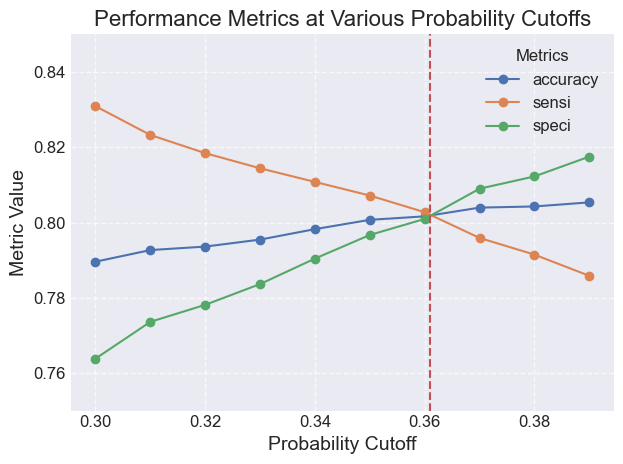

In [101]:
# Plotting accuracy, sensitivity, and specificity
plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
cutoff_df.plot.line(x='prob', y=['accuracy', 'sensi', 'speci'], marker='o')

# Adding titles and labels
plt.title('Performance Metrics at Various Probability Cutoffs', fontsize=16)
plt.xlabel('Probability Cutoff', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.ylim(0.75, .85)  # Set y-axis limits to [0, 1] for clarity

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding a legend with better positioning
plt.legend(title='Metrics', fontsize=12, loc='best')

plt.axvline(x=0.361, color='r', linestyle='--') # additing axline to manual identify 3rd digit

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()


## **Mapping-using the cut off value 0.361**

In [102]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.361 else 0)

# dropping earlier predicted values
y_train_pred_final.drop(numbers, axis = 1, inplace = True)

y_train_pred_final.head()

Converted  Conversion_Prob  Predicted  final_predicted
0          0         0.089747          0                0
1          1         0.712647          1                1
2          0         0.637440          1                1
3          0         0.082148          0                0
4          0         0.575321          1                1

In [103]:
# display confusion metrics using locally defined function
show_confusion_mets(y_train_pred_final, 'Converted', 'final_predicted')

Accuracy : 80.21
Confusion Matrix :
--------------------
[[3195  789]
 [ 491 1993]]
--------------------
Sensitivity : 80.23
Specificity : 80.2
False Positive Rate : 19.8
Positive predictive power : 71.64
Negative predictive power : 86.68
Precision : 71.64
Recall : 80.23
F1 score: 75.69


The model achieved an accuracy, sensitivity and specificity of over **80%**, indicating a well-performing model in distinguishing between converted and non-converted leads with a cut off of 0.361.

#### Prediction on Test - Using Various Probability Cut off Curves

In [104]:
# Scaling numeric values
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [105]:
# replicating all the columns from the final training model
cols = X_train.columns

X_test = X_test[cols]

X_test.columns

Index(['Total Time Spent on Website', 'Page Views Per Visit', 'Lead Origin_Lead Add Form', 'Do Not Email_Yes', 'Last Activity_Email Opened', 'Last Activity_SMS Sent', 'What is your current occupation_Other', 'What is your current occupation_Working Professional', 'Last Notable Activity_Had a Phone Conversation', 'Last Notable Activity_Modified', 'Last Notable Activity_Unreachable', 'Last Notable Activity_Unsubscribed'], dtype='object')

In [106]:
# Make predictions on the test set and store it in the variable 'y_test_pred'

y_test_pred = res.predict(sm.add_constant(X_test))

print(len(X_test.columns))
X_test.columns

12


Index(['Total Time Spent on Website', 'Page Views Per Visit', 'Lead Origin_Lead Add Form', 'Do Not Email_Yes', 'Last Activity_Email Opened', 'Last Activity_SMS Sent', 'What is your current occupation_Other', 'What is your current occupation_Working Professional', 'Last Notable Activity_Had a Phone Conversation', 'Last Notable Activity_Modified', 'Last Notable Activity_Unreachable', 'Last Notable Activity_Unsubscribed'], dtype='object')

In [107]:
# Converting y_pred to a dataframe

y_pred_1 = pd.DataFrame(y_test_pred)


y_pred_1.head()

0
4608  0.256642
7935  0.034541
4043  0.024483
7821  0.802265
856   0.087223

In [108]:
# Converting y_test to dataframe

y_test_df = pd.DataFrame(y_test)

In [109]:
# Remove index for both dataframes to append them side by side 

y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [110]:
# Append y_test_df and y_pred_1

y_test_pred_final = pd.concat([y_test_df, y_pred_1], axis=1)

# Rename the column 

y_test_pred_final= y_test_pred_final.rename(columns = {0 : 'Conversion_Prob'})

y_test_pred_final.head()

Converted  Conversion_Prob
0          1         0.256642
1          0         0.034541
2          0         0.024483
3          0         0.802265
4          0         0.087223

In [111]:
# Make predictions on the test set using 0.36 as the cutoff

y_test_pred_final['final_predicted'] = y_test_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.361 else 0)

In [112]:
# Check y_pred_final

y_test_pred_final.head()

Converted  Conversion_Prob  final_predicted
0          1         0.256642                0
1          0         0.034541                0
2          0         0.024483                0
3          0         0.802265                1
4          0         0.087223                0

In [113]:
show_confusion_mets(y_test_pred_final, 'Converted', 'final_predicted')

Accuracy : 81.42
Confusion Matrix :
--------------------
[[1348  347]
 [ 168  909]]
--------------------
Sensitivity : 84.4
Specificity : 79.53
False Positive Rate : 20.47
Positive predictive power : 72.37
Negative predictive power : 88.92
Precision : 72.37
Recall : 84.4
F1 score: 77.93


#**Result on test set seems good!**  @@@Surinder

**Thershold based on Precision-Recall**

In [114]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

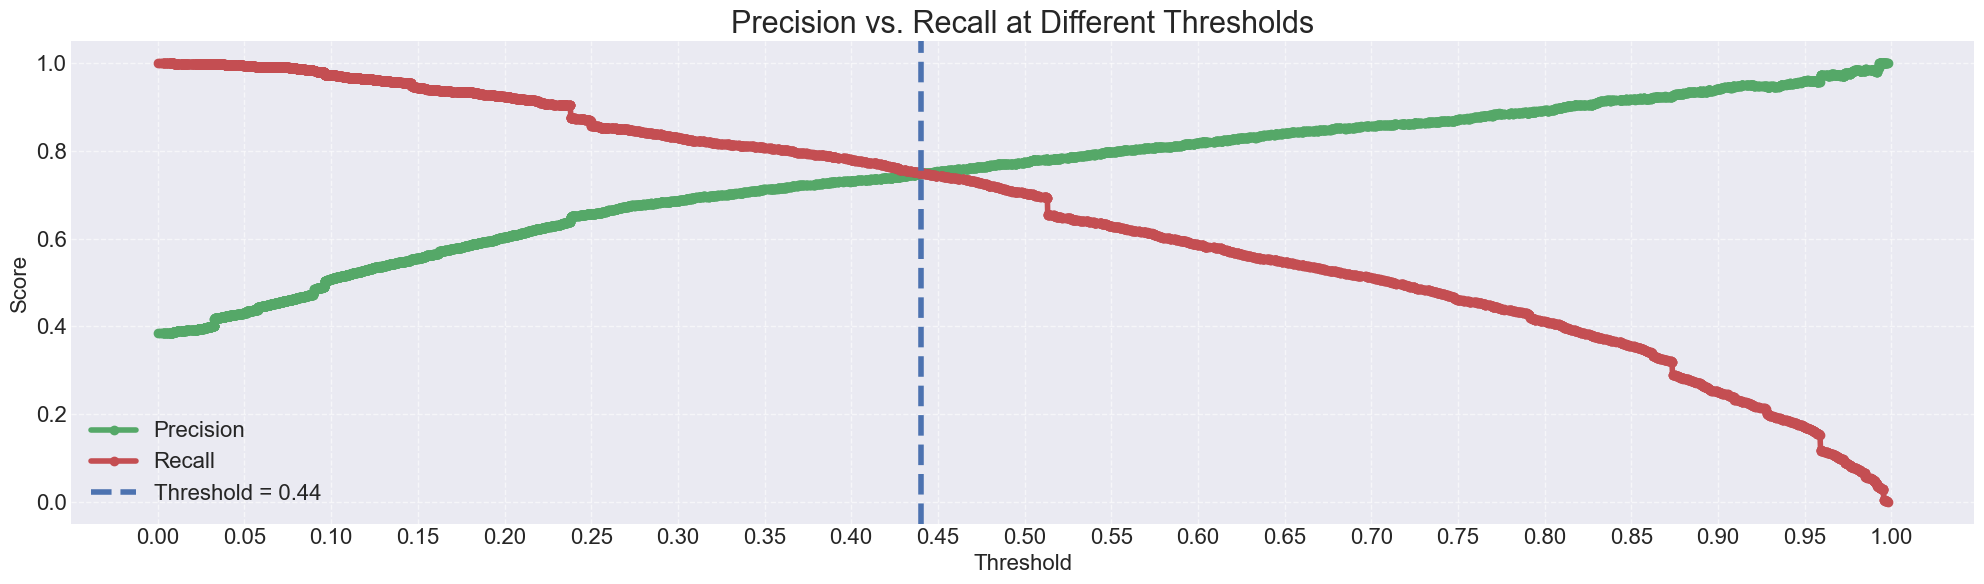

In [115]:
plt.figure(figsize=(20, 6))  # Adjust the figure size for better readability

# Plot Precision (in green) and Recall (in red)
plt.plot(thresholds, p[:-1], "g-", label="Precision", linewidth=4, marker = 'o')
plt.plot(thresholds, r[:-1], "r-", label="Recall", linewidth=4, marker = 'o')

# Add a vertical line at the threshold 0.44
plt.axvline(x=0.44, color='b', linestyle='--', linewidth=4, label="Threshold = 0.44")

# Titles and labels
plt.title('Precision vs. Recall at Different Thresholds', fontsize=22)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Score', fontsize=16)

# Customize ticks and their sizes
plt.xticks(np.arange(0, 1.01, step=0.05), size=16)  # Adjust step for clarity
plt.yticks(size=16)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
plt.legend(fontsize=16, loc='best')

# Tight layout to prevent overlaps
plt.tight_layout()

# Display the plot
plt.show()


**Mapping-using the cut off value 0.44**

In [116]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.44 else 0)

y_train_pred_final.head()

Converted  Conversion_Prob  Predicted  final_predicted
0          0         0.089747          0                0
1          1         0.712647          1                1
2          0         0.637440          1                1
3          0         0.082148          0                0
4          0         0.575321          1                1

In [117]:
# display confusion metrics 
show_confusion_mets(y_train_pred_final, 'Converted', 'final_predicted')

Accuracy : 80.67
Confusion Matrix :
--------------------
[[3356  628]
 [ 622 1862]]
--------------------
Sensitivity : 74.96
Specificity : 84.24
False Positive Rate : 15.76
Positive predictive power : 74.78
Negative predictive power : 84.36
Precision : 74.78
Recall : 74.96
F1 score: 74.87


**Prediction on Test - Using Various Probability Cut off Curves**

In [118]:
# Append y_test_df and y_pred_1

y_test_pred_final = pd.concat([y_test_df, y_pred_1], axis=1)

# Rename the column 

y_test_pred_final= y_test_pred_final.rename(columns = {0 : 'Conversion_Prob'})

y_test_pred_final.head()



Converted  Conversion_Prob
0          1         0.256642
1          0         0.034541
2          0         0.024483
3          0         0.802265
4          0         0.087223

In [119]:
y_test_pred_final['final_predicted'] = y_test_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.44 else 0)

In [120]:
# Check y_pred_final

y_test_pred_final.head()

Converted  Conversion_Prob  final_predicted
0          1         0.256642                0
1          0         0.034541                0
2          0         0.024483                0
3          0         0.802265                1
4          0         0.087223                0

In [121]:
show_confusion_mets(y_test_pred_final, 'Converted', 'final_predicted')

Accuracy : 82.61
Confusion Matrix :
--------------------
[[1432  263]
 [ 219  858]]
--------------------
Sensitivity : 79.67
Specificity : 84.48
False Positive Rate : 15.52
Positive predictive power : 76.54
Negative predictive power : 86.74
Precision : 76.54
Recall : 79.67
F1 score: 78.07


- Based on the comparison of results for both the cut offs, proceeding with cutoff 0.361 because it offers a higher recall (84.4%), which is crucial for maximizing the number of converted leads.
- While precision (72.37%) is slightly lower, the trade-off is acceptable as recall aligns with the goal of identifying more potential conversions.


In [122]:
y_test_pred_final['final_predicted'] = y_test_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.361 else 0)

Comparing Training set evaluation metrics with test set metrics

In [123]:
print('Train Data Set metrics: ')
print()
show_confusion_mets(y_train_pred_final, 'Converted', 'final_predicted')
print()
print('Test Data Set metrics:/n')
print()
show_confusion_mets(y_test_pred_final, 'Converted', 'final_predicted')

Train Data Set metrics: 

Accuracy : 80.67
Confusion Matrix :
--------------------
[[3356  628]
 [ 622 1862]]
--------------------
Sensitivity : 74.96
Specificity : 84.24
False Positive Rate : 15.76
Positive predictive power : 74.78
Negative predictive power : 84.36
Precision : 74.78
Recall : 74.96
F1 score: 74.87

Test Data Set metrics:/n

Accuracy : 81.42
Confusion Matrix :
--------------------
[[1348  347]
 [ 168  909]]
--------------------
Sensitivity : 84.4
Specificity : 79.53
False Positive Rate : 20.47
Positive predictive power : 72.37
Negative predictive power : 88.92
Precision : 72.37
Recall : 84.4
F1 score: 77.93


### Assigning a lead score to each of the leads

In [124]:
# Assigning a Lead Score to the Training Dataset
y_train_pred_final.head()

Converted  Conversion_Prob  Predicted  final_predicted
0          0         0.089747          0                0
1          1         0.712647          1                1
2          0         0.637440          1                1
3          0         0.082148          0                0
4          0         0.575321          1                1

In [125]:
y_train_pred_final = y_train_pred_final[['Converted', 'Conversion_Prob', 'final_predicted']]

y_train_pred_final['Lead Score'] = round(y_train_pred_final['Conversion_Prob'] * 100, 2)

y_train_pred_final.head()

Converted  Conversion_Prob  final_predicted  Lead Score
0          0         0.089747                0        8.97
1          1         0.712647                1       71.26
2          0         0.637440                1       63.74
3          0         0.082148                0        8.21
4          0         0.575321                1       57.53

In [126]:
# Assigning Lead Score to test dataset
y_test_pred_final['Lead Score'] = round(y_test_pred_final['Conversion_Prob'] * 100, 2)
y_test_pred_final.head()

Converted  Conversion_Prob  final_predicted  Lead Score
0          1         0.256642                0       25.66
1          0         0.034541                0        3.45
2          0         0.024483                0        2.45
3          0         0.802265                1       80.23
4          0         0.087223                0        8.72

In [127]:
final_df_lead_score = pd.concat([y_train_pred_final,y_test_pred_final], axis=0)
# including prospect id to link with dataset
final_df_lead_score['Prospect ID'] = leads['Prospect ID']
final_df_lead_score = final_df_lead_score.set_index('Prospect ID')
final_df_lead_score.sort_index(inplace=True)
#final_df_lead_score.head()

In [128]:
final_df_lead_score.shape

(9240, 4)

In [129]:
# setting Prospect ID as index
leads = leads.set_index('Prospect ID')
leads.head(5)

Lead Number              Lead Origin     Lead Source Do Not Email Do Not Call  Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit            Last Activity Country           Specialization How did you hear about X Education What is your current occupation What matters most to you in choosing a course Search Magazine Newspaper Article X Education Forums Newspaper Digital Advertisement Through Recommendations Receive More Updates About Our Courses                                 Tags      Lead Quality Update me on Supply Chain Content Get updates on DM Content    Lead Profile    City Asymmetrique Activity Index Asymmetrique Profile Index  Asymmetrique Activity Score  Asymmetrique Profile Score I agree to pay the amount through cheque A free copy of Mastering The Interview Last Notable Activity
Prospect ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API      Olark Chat           No          No          0          0.0                            0                   0.0  Page Visited on Website     NaN                   Select                             Select                      Unemployed                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No          Interested in other courses  Low in Relevance                                No                        No          Select  Select                   02.Medium                  02.Medium                         15.0                        15.0                                       No                                     No              Modified
2a272436-5132-4136-86fa-dcc88c88f482       660728                      API  Organic Search           No          No          0          5.0                          674                   2.5             Email Opened   India                   Select                             Select                      Unemployed                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No                              Ringing               NaN                                No                        No          Select  Select                   02.Medium                  02.Medium                         15.0                        15.0                                       No                                     No          Email Opened
8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission  Direct Traffic           No          No          1          2.0                         1532                   2.0             Email Opened   India  Business Administration                             Select                         Student                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No  Will revert after reading the email          Might be                      

In [130]:
final_df = pd.merge(leads, final_df_lead_score, how='inner', left_index=True, right_index=True)

final_df.head()

Lead Number              Lead Origin     Lead Source Do Not Email Do Not Call  Converted_x  TotalVisits  Total Time Spent on Website  Page Views Per Visit            Last Activity Country           Specialization How did you hear about X Education What is your current occupation What matters most to you in choosing a course Search Magazine Newspaper Article X Education Forums Newspaper Digital Advertisement Through Recommendations Receive More Updates About Our Courses                                 Tags      Lead Quality Update me on Supply Chain Content Get updates on DM Content    Lead Profile    City Asymmetrique Activity Index Asymmetrique Profile Index  Asymmetrique Activity Score  Asymmetrique Profile Score I agree to pay the amount through cheque A free copy of Mastering The Interview Last Notable Activity  Converted_y  Conversion_Prob  final_predicted  Lead Score
Prospect ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API      Olark Chat           No          No            0          0.0                            0                   0.0  Page Visited on Website     NaN                   Select                             Select                      Unemployed                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No          Interested in other courses  Low in Relevance                                No                        No          Select  Select                   02.Medium                  02.Medium                         15.0                        15.0                                       No                                     No              Modified            1         0.256642                0       25.66
7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API      Olark Chat           No          No            0          0.0                            0                   0.0  Page Visited on Website     NaN                   Select                             Select                      Unemployed                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No          Interested in other courses  Low in Relevance                                No                        No          Select  Select                   02.Medium                  02.Medium                         15.0                        15.0                                       No                                     No              Modified            0         0.089747                0        8.97
2a272436-5132-4136-86fa-dcc88c88f482       660728                      API  Organic Search           No          No            0          5.0                          674                   2.5             Email Opened   India                   Select                             Select                      Unemployed                       Be

In [131]:
final_df.drop('Converted_y',inplace=True,axis=1)
final_df.head(5)

Lead Number              Lead Origin     Lead Source Do Not Email Do Not Call  Converted_x  TotalVisits  Total Time Spent on Website  Page Views Per Visit            Last Activity Country           Specialization How did you hear about X Education What is your current occupation What matters most to you in choosing a course Search Magazine Newspaper Article X Education Forums Newspaper Digital Advertisement Through Recommendations Receive More Updates About Our Courses                                 Tags      Lead Quality Update me on Supply Chain Content Get updates on DM Content    Lead Profile    City Asymmetrique Activity Index Asymmetrique Profile Index  Asymmetrique Activity Score  Asymmetrique Profile Score I agree to pay the amount through cheque A free copy of Mastering The Interview Last Notable Activity  Conversion_Prob  final_predicted  Lead Score
Prospect ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API      Olark Chat           No          No            0          0.0                            0                   0.0  Page Visited on Website     NaN                   Select                             Select                      Unemployed                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No          Interested in other courses  Low in Relevance                                No                        No          Select  Select                   02.Medium                  02.Medium                         15.0                        15.0                                       No                                     No              Modified         0.256642                0       25.66
7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API      Olark Chat           No          No            0          0.0                            0                   0.0  Page Visited on Website     NaN                   Select                             Select                      Unemployed                       Better Career Prospects     No       No                No                 No        No                    No                      No                                     No          Interested in other courses  Low in Relevance                                No                        No          Select  Select                   02.Medium                  02.Medium                         15.0                        15.0                                       No                                     No              Modified         0.089747                0        8.97
2a272436-5132-4136-86fa-dcc88c88f482       660728                      API  Organic Search           No          No            0          5.0                          674                   2.5             Email Opened   India                   Select                             Select                      Unemployed                       Better Career Prospects     No       No               

Lead Score has ben assigned as required by the management against each Lead. This would provide a prioritization ranking for the sales team to prioritize leads, by focussing on higher value lead scores and working downwards.

### Feature importance of the final model

In [132]:
res.params

const                                                  -1.641238
Total Time Spent on Website                             4.007871
Page Views Per Visit                                   -7.074238
Lead Origin_Lead Add Form                               3.097061
Do Not Email_Yes                                       -1.319067
Last Activity_Email Opened                              0.476628
Last Activity_SMS Sent                                  1.693897
What is your current occupation_Other                  -1.152117
What is your current occupation_Working Professional    2.252586
Last Notable Activity_Had a Phone Conversation          3.792677
Last Notable Activity_Modified                         -0.599572
Last Notable Activity_Unreachable                       2.554232
Last Notable Activity_Unsubscribed                      1.630574
dtype: float64

In [133]:
# identifying top parameters
feature_importance = res.params[1:]    #Ignoring the constant
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top3 = feature_importance.sort_values(ascending=False)[:3]
feature_importance.sort_values(ascending=False)

Total Time Spent on Website                             100.000000
Last Notable Activity_Had a Phone Conversation           94.630713
Lead Origin_Lead Add Form                                77.274455
Last Notable Activity_Unreachable                        63.730388
What is your current occupation_Working Professional     56.204040
Last Activity_SMS Sent                                   42.264247
Last Notable Activity_Unsubscribed                       40.684283
Last Activity_Email Opened                               11.892290
Last Notable Activity_Modified                          -14.959863
What is your current occupation_Other                   -28.746346
Do Not Email_Yes                                        -32.911915
Page Views Per Visit                                   -176.508609
dtype: float64

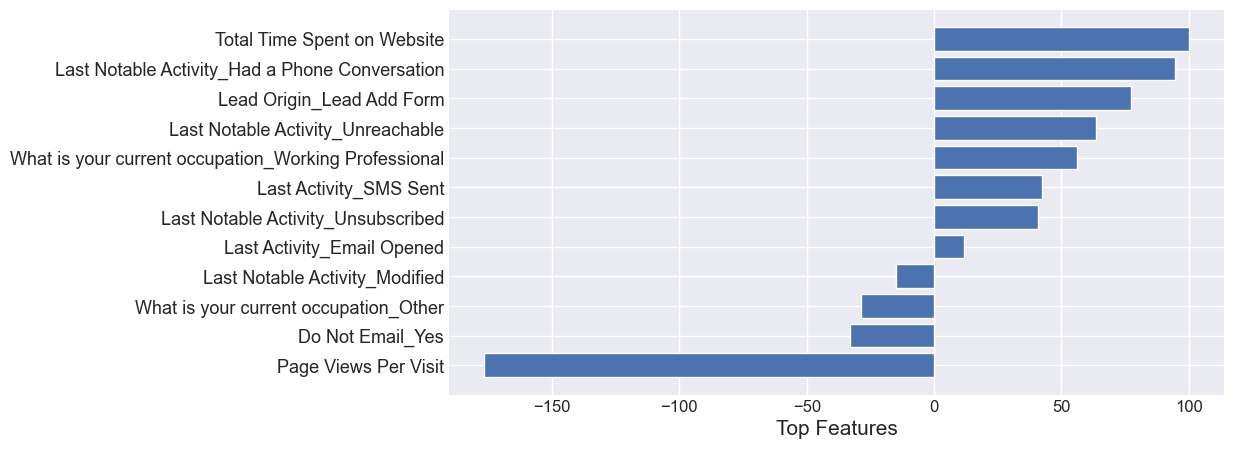

In [134]:
# Plotting the feature variables based on their relative importance:-

top_feature_sort = np.argsort(feature_importance, kind='quicksort', order='list of str')

pos = np.arange(top_feature_sort.shape[0]) + .5

fig1 = plt.figure(figsize=(10,5))
ax = fig1.add_subplot(1, 1, 1)
ax.barh(pos, feature_importance[top_feature_sort])
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X_train.columns)[top_feature_sort], fontsize=13)
ax.set_xlabel('Top Features', fontsize=15)
plt.show()

In [135]:
top3

Total Time Spent on Website                       100.000000
Last Notable Activity_Had a Phone Conversation     94.630713
Lead Origin_Lead Add Form                          77.274455
dtype: float64

<B>Q: Which are the top three variables in your model which contribute most towards the probability of a lead getting converted? </B>

Ans: The top three variables in the final model which contribute most towards the probability of lead getting converted are:

- Total Time Spent on Website
- Last Notable Activity
- Lead Origin

The maximum negative pull comes from low Page Views Per Visit

<B>Q: What are the top 3 categorical/dummy variables in the model which should be focused the most on in order to increase the probability of lead conversion? </B>

- Total Time Spent on Website
- Last Notable Activity_Had a Phone Conversation
- Lead Origin_Lead Add Form

<B>Q: 3.	X Education has a period of 2 months every year during which they hire some interns. The sales team, in particular, has around 10 interns allotted to them. So during this phase, they wish to make the lead conversion more aggressive. So they want almost all of the potential leads (i.e. the customers who have been predicted as 1 by the model) to be converted and hence, want to make phone calls to as much of such people as possible. Suggest a good strategy they should employ at this stage.</B>

All leads with conversion probability of higher than 0.36 or a lead score higher than 36.
Target customers who :
- spend more than 4 minutes on Website,
- Lead originated from the Lead Add Form,
- Customers who opened the email from X Education,
- and, those who are Working proffessionals.


<B>Q: 4.	Similarly, at times, the company reaches its target for a quarter before the deadline. During this time, the company wants the sales team to focus on some new work as well. So during this time, the company’s aim is to not make phone calls unless it’s extremely necessary, i.e. they want to minimize the rate of useless phone calls. Suggest a strategy they should employ at this stage.</B>

Implement an inbound IVR and automated responses or recommendations.
Create a chatbot for the most commonly asked questions.

Do not focus on unemployed leads. They might not have a budget to spend on the course Do not focus on students, since they are already studying and would not be willing to enrol 
into a course specially designed for working professionals, so early in the tenure

In [136]:

### updated at 1.03 AM 20 Oct
### updated at 14.57 20 Oct

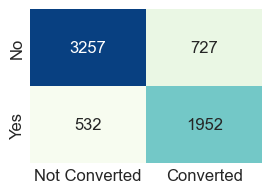

In [137]:
cmRes = pd.DataFrame(cm1, columns=['Not Converted', 'Converted'], index=['No', 'Yes'])
plt.figure(figsize=(3,2))
sns.heatmap(cmRes, annot=True, fmt='g', cmap='GnBu', cbar=False);